<h1>Birthweight Dataset</h1>
<p>Finding which is the best model to predict the weight of babies before they are born.</p> 

In [1]:
#import libraries
import pandas as pd #dataframe essencials
import numpy as np #data manipulation
import seaborn as sns #better visuals
import matplotlib.pyplot as plt #visualizations
pd.set_option('display.max_rows', 500) #increasing print desplays
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<p>Reading the dataset and checking the columns and what information they provide.</p>
<p>The columns showing the babies score on the apgar tests are dropped because they will not prove useful for our model. Although they might give insight as to what the weight of the baby was when it was born, these tests are not done until after the baby is born, and therefore would render our model useless.</p>

In [2]:
#read file
data = pd.read_excel("birthweight_low.xlsx")
data.drop(columns = ['omaps', 'fmaps'], inplace = True) #drop variables we cannot use in the model because they are not given until after the baby is born
#Also I did not have the extra unnamed columns when I first read the data so I didnt need to drop them
data.head() 

,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght
0,69,NaN,5,2.0,62,NaN,23,9,1,0,1,0,0,1,0,697
1,68,12.0,3,10.0,61,11.0,25,11,1,1,0,0,1,0,0,1290
2,71,12.0,3,6.0,46,12.0,21,12,1,0,1,0,0,1,0,1490
3,59,16.0,1,8.0,48,16.0,21,10,0,0,0,1,0,0,1,1720
4,48,12.0,4,6.0,39,12.0,17,13,0,1,0,0,1,0,0,1956


In [3]:
print(f"""
Size of Original Dataset
------------------------
Observations: {data.shape[0]} 
Features:     {data.shape[1]}
""") #printing the shape of the dataset


Size of Original Dataset
------------------------
Observations: 196 
Features:     16



In [4]:
df2 = data.copy()
df2.drop(columns = ['bwght'], inplace = True)
df2duplicates = df2[df2.duplicated()]
len(df2duplicates)
#there seem to be no twins in the data (all observations may be independent), so we are not breaking one of the assumptions of OLS directly

0

In [5]:
data.info() #general info on types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mage    196 non-null    int64  
 1   meduc   193 non-null    float64
 2   monpre  196 non-null    int64  
 3   npvis   193 non-null    float64
 4   fage    196 non-null    int64  
 5   feduc   189 non-null    float64
 6   cigs    196 non-null    int64  
 7   drink   196 non-null    int64  
 8   male    196 non-null    int64  
 9   mwhte   196 non-null    int64  
 10  mblck   196 non-null    int64  
 11  moth    196 non-null    int64  
 12  fwhte   196 non-null    int64  
 13  fblck   196 non-null    int64  
 14  foth    196 non-null    int64  
 15  bwght   196 non-null    int64  
dtypes: float64(3), int64(13)
memory usage: 24.6 KB


<h2>Checking Missing Values</h2>
<p>There are few missing values in the dataframe, however since the dataset is very small these could have an effect on the results. The mother's education and father's education are highly correlated, but both have missing values, so instead I figured there would also be a correlation between their education level and the month that they started going to the doctor to check on their pregnancies. </p>

In [6]:
# looping to detect features with missing values
for col in data:

    # creating columns with 1s if missing and 0 if not
    if data[col].isnull().astype(int).sum() > 0:
        data['m_'+col] = data[col].isnull().astype(int)


In [7]:
bw = data.copy()
#copy the data to avoid editing the original

bw['meduc'].fillna(value = bw.groupby('monpre')['meduc'].transform('median'), inplace = True)
bw['feduc'].fillna(value = bw.groupby('monpre')['feduc'].transform('median'), inplace = True)
bw['npvis'].fillna (value = bw['npvis'].median(), inplace = True)
#imputing missing values with the median of each group of months that people started going to the doctor


#looping over the dataset and logging the x variables if they have a skew value above 0.5
for col in bw:
    if  (bw[col].dtype == 'int64' or bw[col].dtype == 'float64') and np.abs(bw[col].skew()) >= 0.5:
        if col in ('omaps', 'fmaps'):
            break
        elif bw[col].min() == 0 and bw[col].value_counts().count() == 2:
            break
        elif bw[col].min() == 0: 
            bw['log_' + col] = np.log(bw[col] + 0.9)
        elif bw[col].min() > 0: 
            bw['log_' + col] = np.log(bw[col])
        else:
            print('Error')
            
#logging the y variable
bw['log_' + 'bwght'] = np.log(bw['bwght'])  

<h2>Feature Engineering</h2>
<p>Below are all the columns I tried to feature engineer. Some were thought out, others were done just to check if there was a relationship that I was not noticing </p> 

In [8]:
# multiplying columns to see if a higher value on both is more explicit than having them seperate
bw['mage2'] = bw['mage'] *  bw['mage']
bw['monpre2'] = bw['monpre'] *  bw['monpre']
bw['cigs_drink'] = bw['cigs'] *  bw['drink']
bw['cigs_mage'] = bw['mage'] *  bw['cigs']
bw['drink_mage'] = bw['mage'] *  bw['drink']
bw['cigs2'] = bw['cigs'] * bw['cigs']
bw['drink2'] = bw['drink'] *  bw['drink']
bw['month_pren_visits'] = bw['npvis']* bw['monpre']
bw['mage_meduc'] = bw['mage'] *  bw['meduc']
bw['fage_feduc'] = bw['fage'] *  bw['feduc']

#dividing colums to get ratios of education and age
bw['fage/feduc'] = bw['fage'] /  bw['feduc']
bw['mage/meduc'] = bw['mage'] /  bw['meduc']
bw['feduc/fage'] =   bw['feduc'] /bw['fage'] 
bw['meduc/mage'] =   bw['meduc'] /bw['mage'] 


#maybe races have some effect when both parents are taken into account, not separately
bw['parents_white'] = bw['mwhte'] * bw['fwhte']
bw['parents_black'] = bw['mblck'] * bw['fblck']
bw['parents_other'] = bw['moth'] * bw['foth']


bw['any_white'] = bw['mwhte'] + bw['fwhte']
bw['any_white'] = np.where(bw['any_white'] >= 1 , 1, 0)
bw['any_black'] = bw['mblck'] + bw['fblck']
bw['any_black'] = np.where(bw['any_black'] >= 1 , 1, 0)

#comparing education and race
bw['education'] = bw['meduc'] + bw['feduc']
bw['parents_educ_white'] = bw['parents_white'] * bw['education']
bw['parents_educ_black'] = bw['parents_black'] * bw['education']
bw['parents_educ_other'] = bw['parents_other'] * bw['education']

bw['mom_race'] = np.where(bw['mwhte'] == 1, "white", np.where(bw['mblck'] == 1,'black', 'other'))

#working with things we are not supposed to do while smoking
bw['sins'] = bw['cigs'] + bw['drink']
bw['smoker'] = np.where(bw['cigs'] > 1 , 1, 0)
bw['drinker'] = np.where(bw['drink'] > 1 , 1, 0)

#maybe grouping ages will have a better effect
bw['ages'] = bw['mage'] + bw['fage']
bw["ages_over_80"] = np.where(bw['ages'] >= 86, 1, 0)
bw["mom_over_40"] = np.where(bw['mage'] >= 40, 1, 0)
bw["mom_over_45"] = np.where(bw['mage'] >= 45, 1, 0)
bw["mom_over_35"] = np.where(bw['mage'] >= 36, 1, 0)
bw["mom_over_30"] = np.where(bw['mage'] >= 31, 1, 0)
bw["dad_over_40"] = np.where(bw['fage'] >= 40, 1, 0)

#weird ratios i thought would help but did not
bw["mage:cigs"] = bw['mage']/(bw['cigs'].max()+1 - bw['cigs'])
bw["mage:drink"] = bw['mage']/(bw['drink'].max()+1 - bw['drink'])
bw["mage:meduc"] = bw['mage']/(bw['meduc'].max()+1 - bw['meduc'])

#maybe having over a certain number of visits is bad, or having too little vs too much is the same
bw['visits_over_8'] = np.where(bw['npvis'] >= 9 , 1, 0)
bw['visits_over_9'] = np.where(bw['npvis'] >= 10 , 1, 0)
bw['visits_doctor'] = np.where(bw['npvis'] >= 7 , np.where(bw['npvis'] >= 14, "many_visits", "mid_visits"), "few_visits")

#grouping different columns and even those i had previously engineered
bw['prenatal_month_over_4'] = np.where(bw['monpre'] >= 4 , 1, 0)
bw['mom_over_hs'] = np.where(bw['meduc'] > 12, 1, 0)
bw['dad_over_hs'] = np.where(bw['feduc'] > 12, 1, 0)
bw['parents_over_40'] = bw['mom_over_40']*bw['dad_over_40']
bw['exp_mom_age'] = -1**bw['mage']
bw['parents_over_hs'] = bw['mom_over_hs']*bw['dad_over_hs']
bw['mom_educs'] = np.where(bw['meduc'] > 12, np.where(bw['meduc'] > 16,"UNI","HS"), "UNDER")
bw['mom_ages'] = np.where(bw['mage'] > 30, np.where(bw['mage'] > 40,"old","mid"), "young")
bw['mom_age_drinks'] = bw['mage'] * bw['drink']
bw['cigs_mom_age'] = bw['cigs'] * bw['mage']

#i'm not entirely sure why I thought changing the regression midway would work
bw['mom_age_cigs'] = np.where(bw['mage'] > 40, (bw['mage'] *bw['mage'] * (bw['cigs'])), (bw['mage'] * bw['cigs']))
bw['mom_age_drinks_cigs'] = bw['mage'] * (bw['cigs'] * bw['drink'])

#ratio of visits
bw['frequency_visits'] = bw['npvis']/(9 - bw['monpre'])

#squaring some columns
bw['mom_age2'] = bw['mage']**2
bw['pren_visits2'] = bw['npvis']**2

#dummies for bins that were created
one_hot_visits = pd.get_dummies(bw['visits_doctor'])
one_hot_mom_educ = pd.get_dummies(bw['mom_educs'])
one_hot_mom_ages = pd.get_dummies(bw['mom_ages'])

#joining dummies to original df
bw = bw.join([one_hot_visits])
bw = bw.join([one_hot_mom_educ])
bw = bw.join([one_hot_mom_ages])

<p>Locked cells used to analyze the variables to create the new columns.</p>

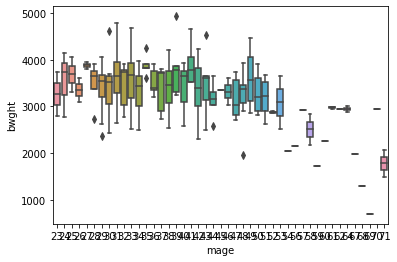

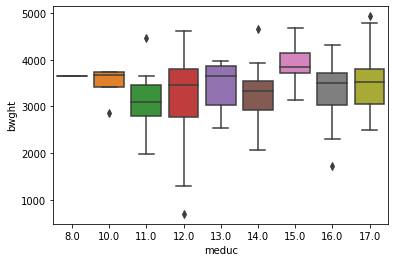

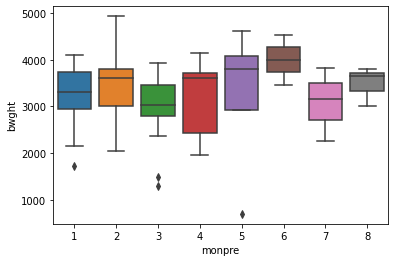

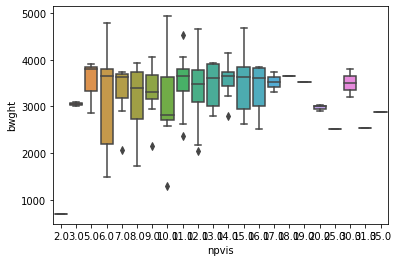

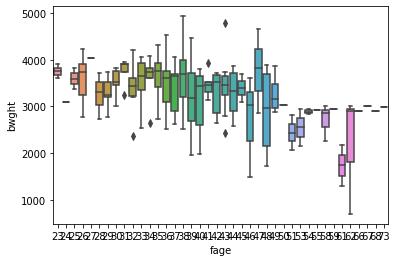

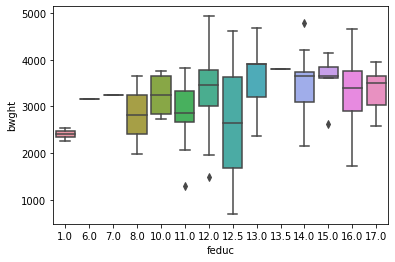

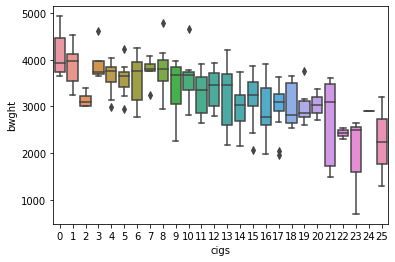

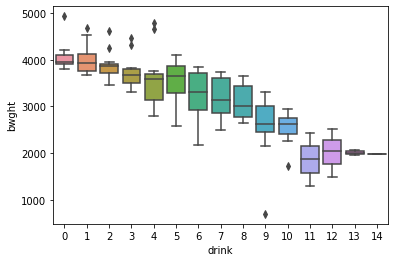

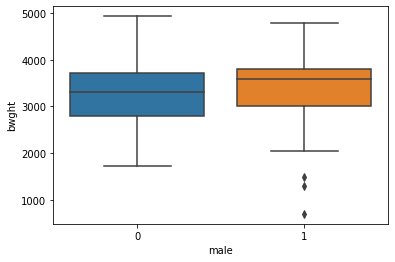

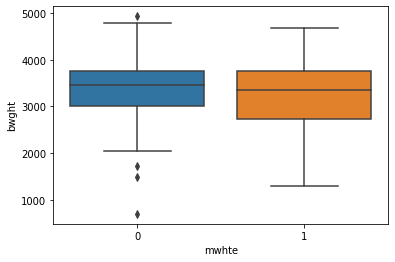

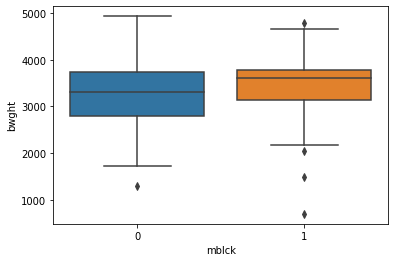

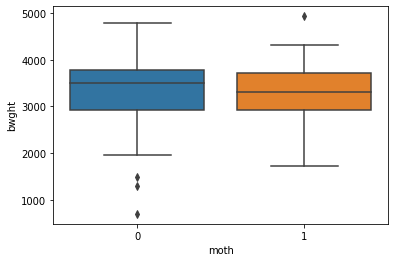

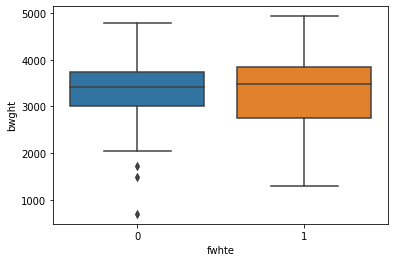

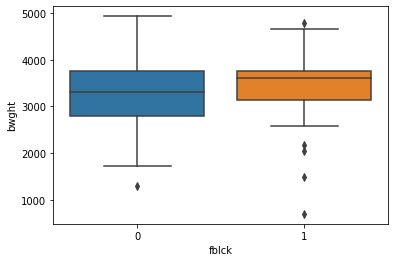

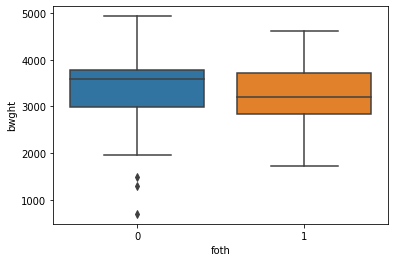

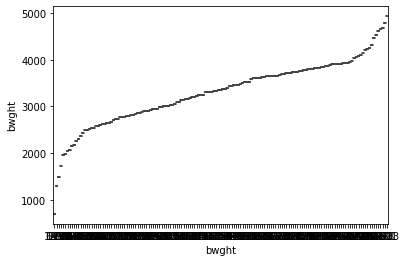

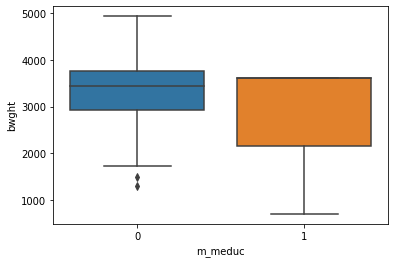

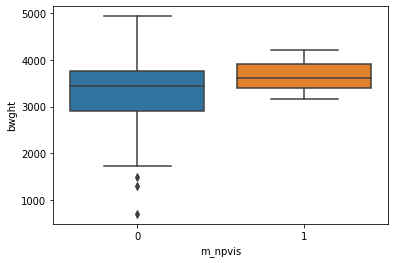

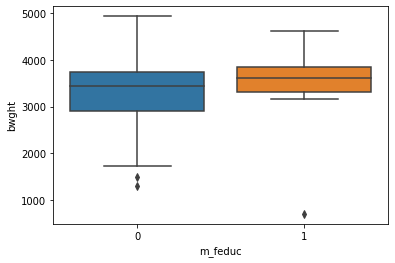

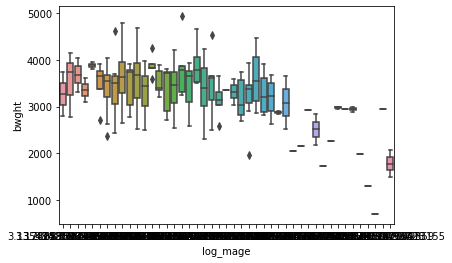

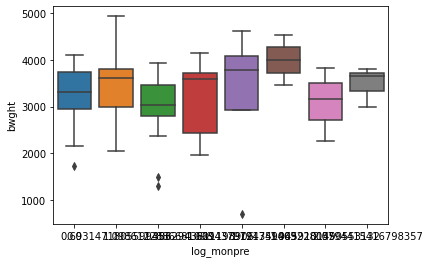

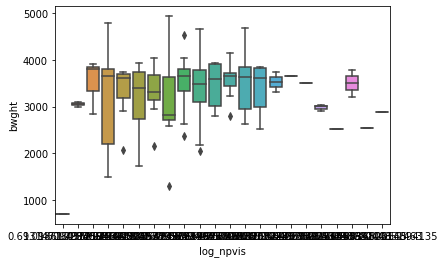

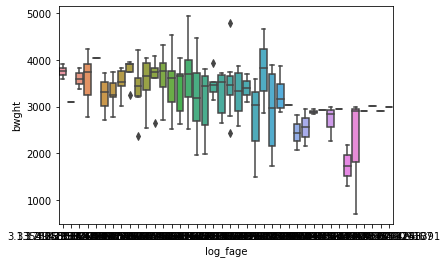

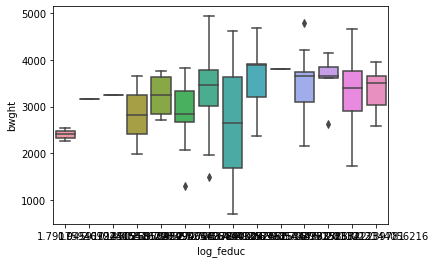

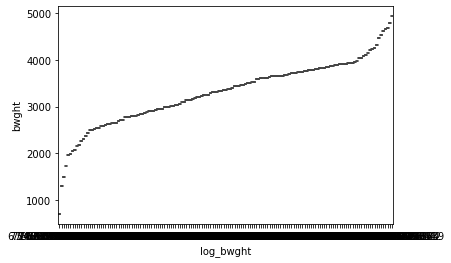

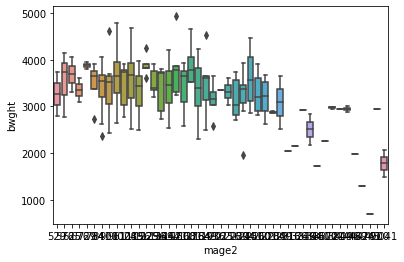

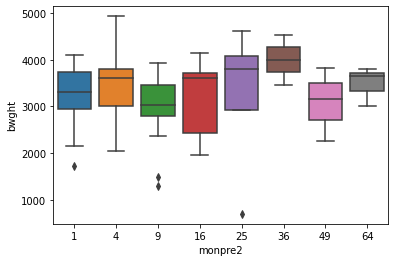

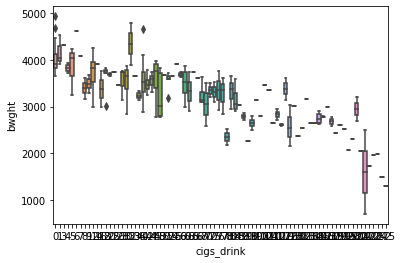

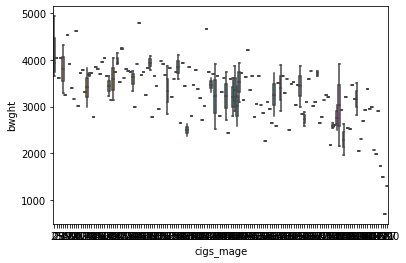

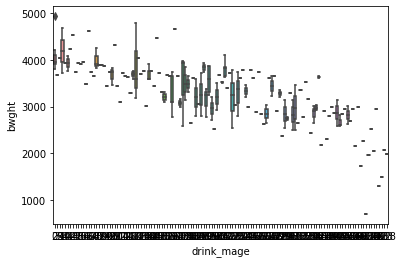

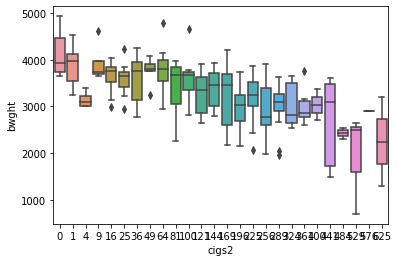

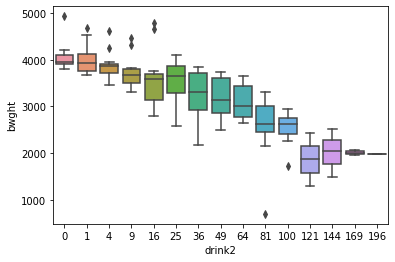

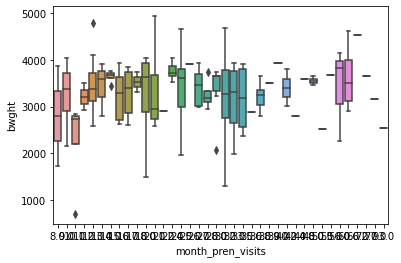

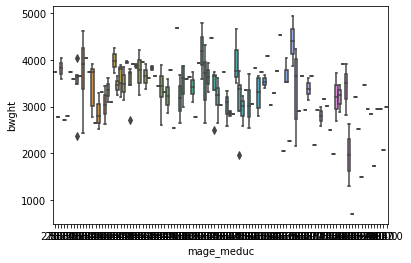

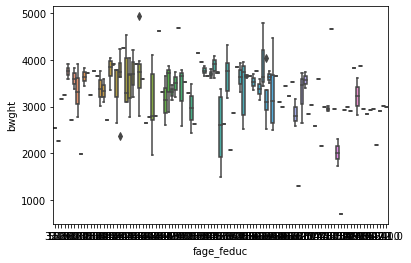

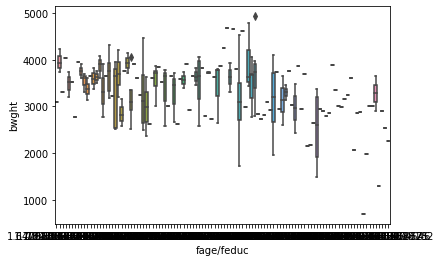

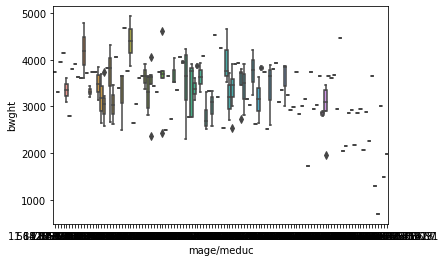

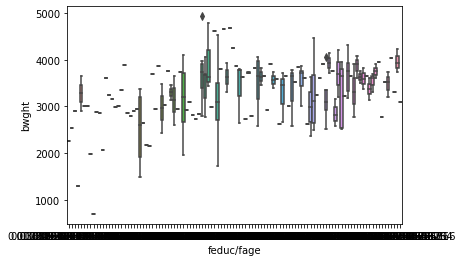

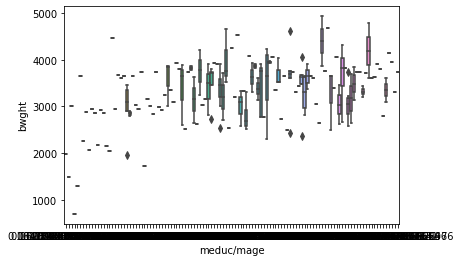

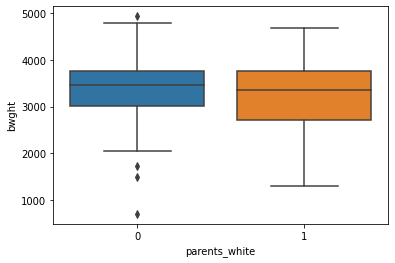

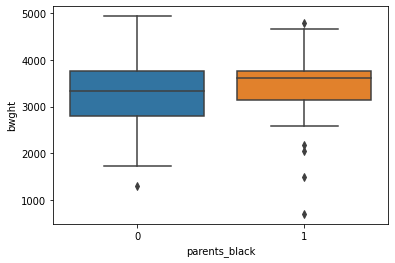

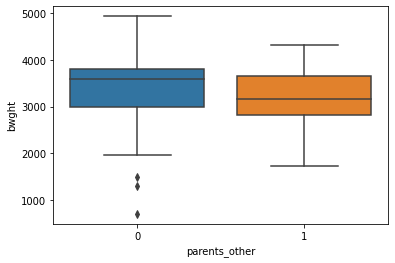

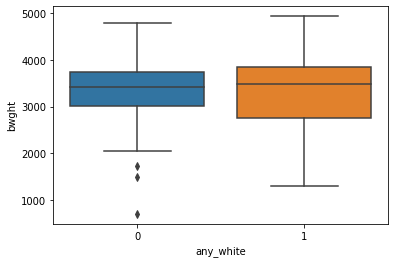

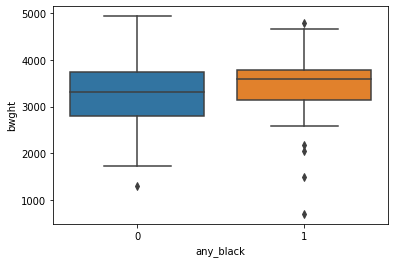

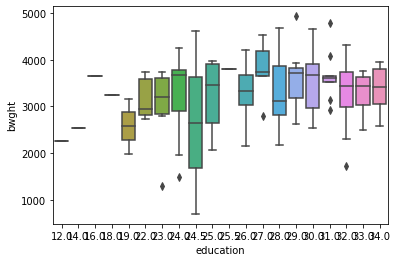

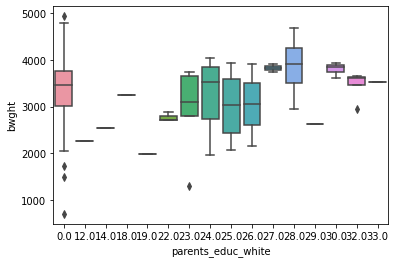

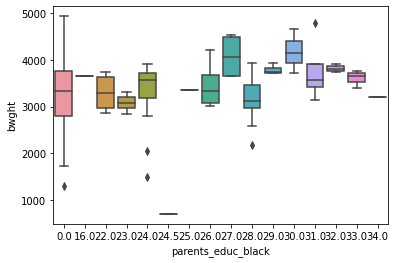

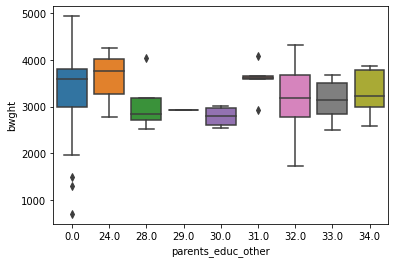

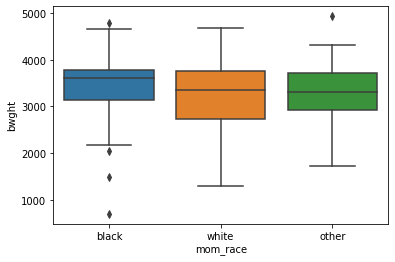

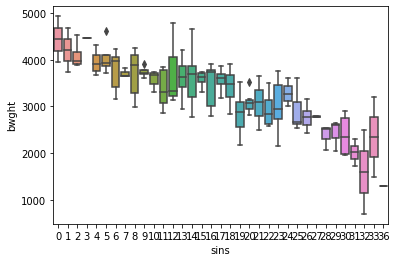

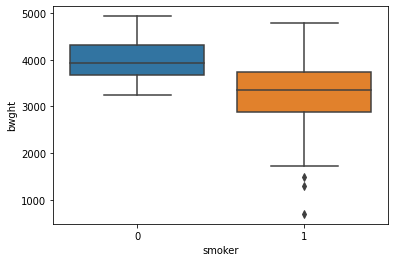

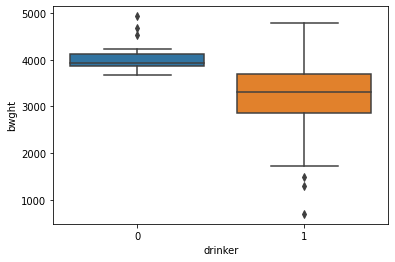

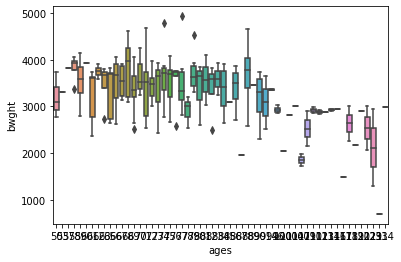

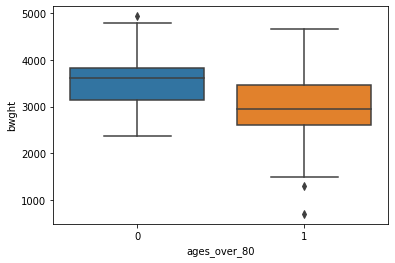

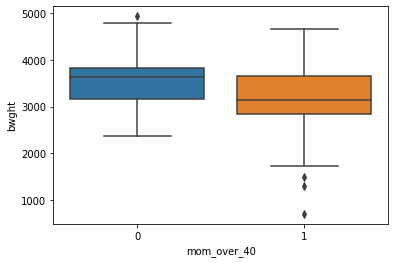

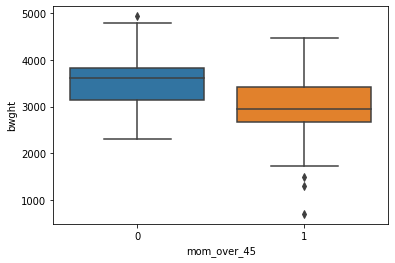

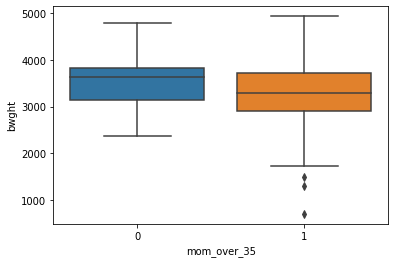

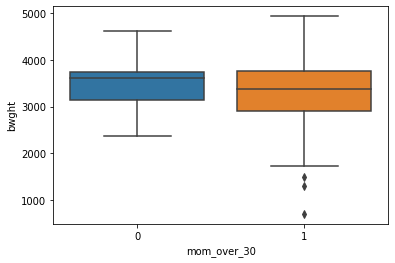

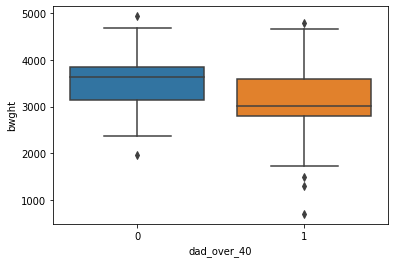

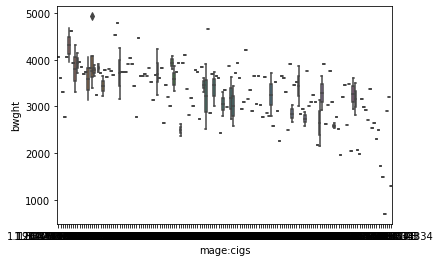

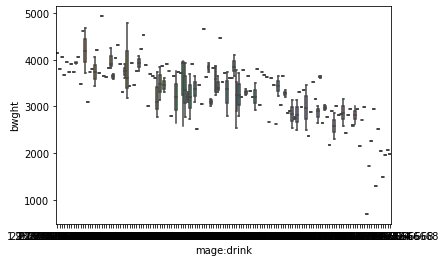

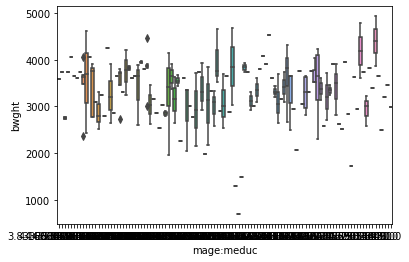

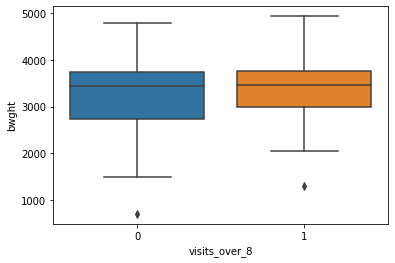

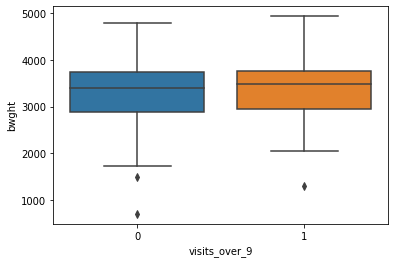

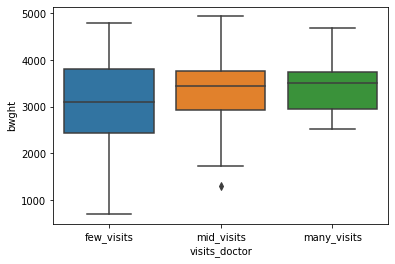

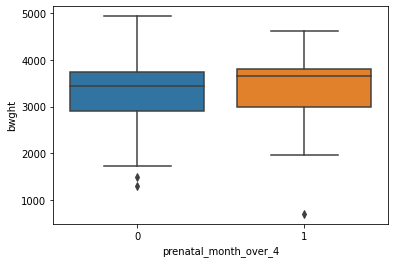

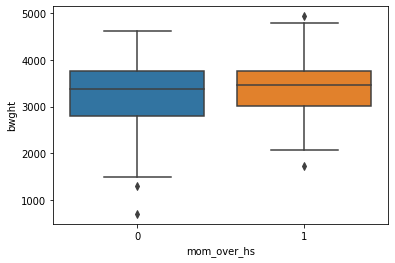

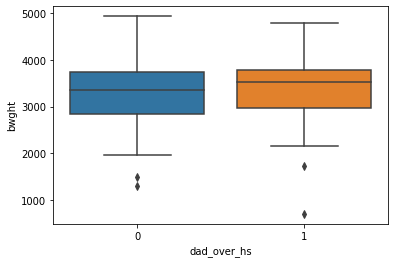

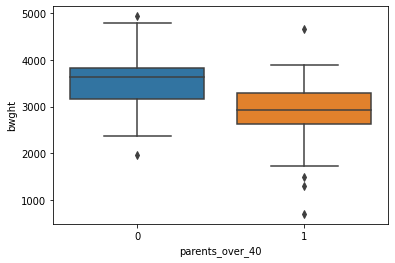

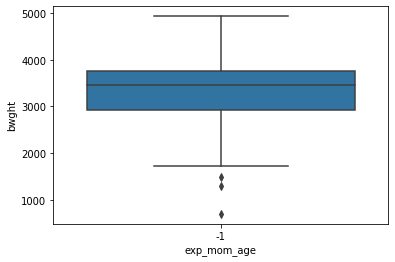

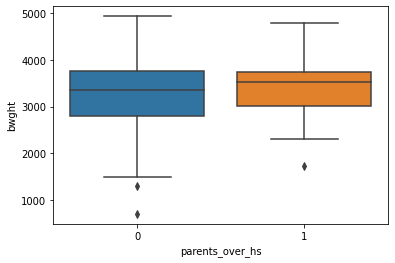

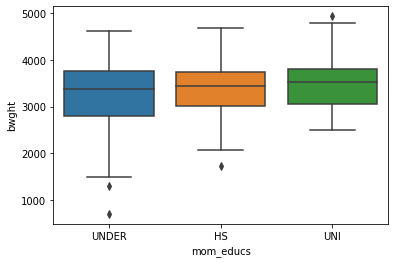

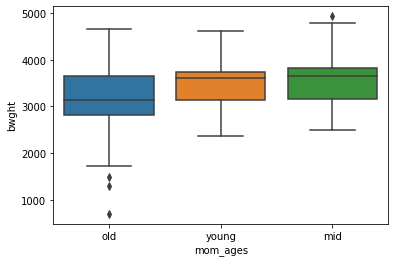

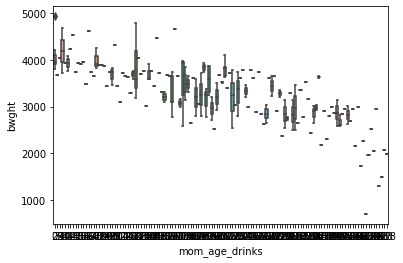

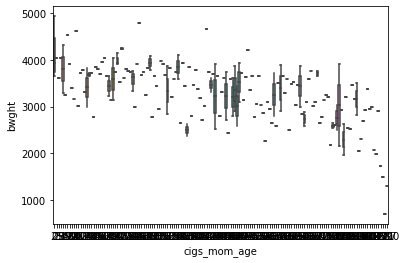

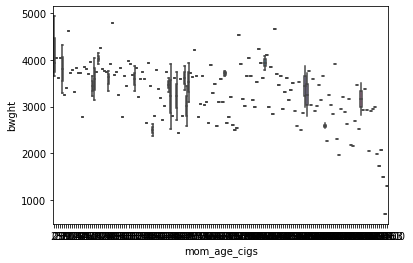

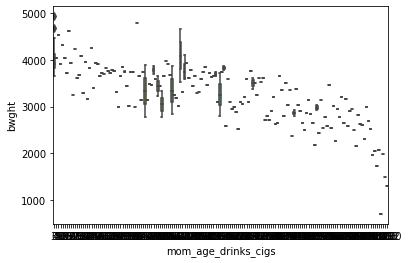

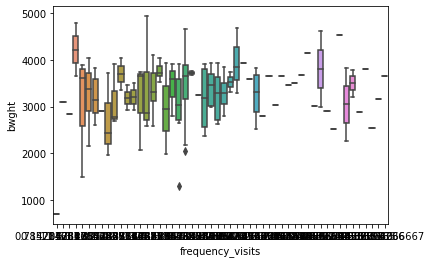

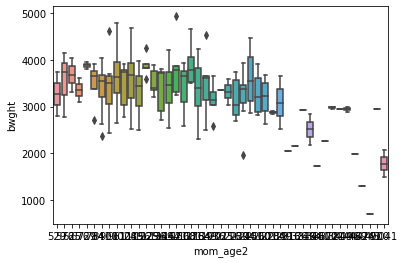

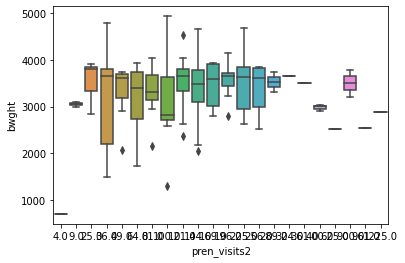

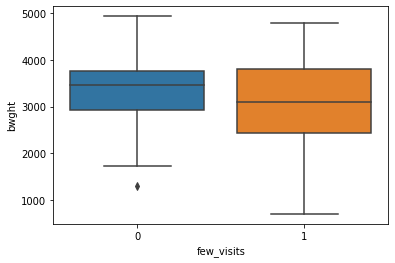

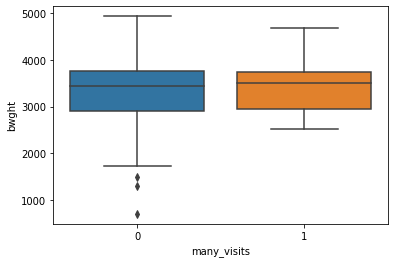

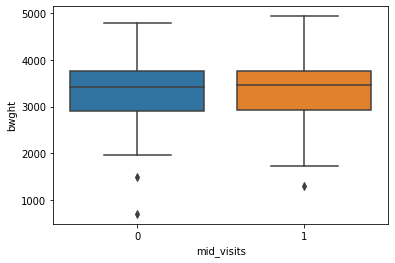

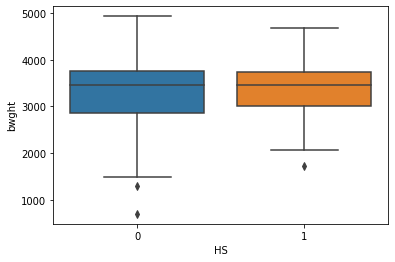

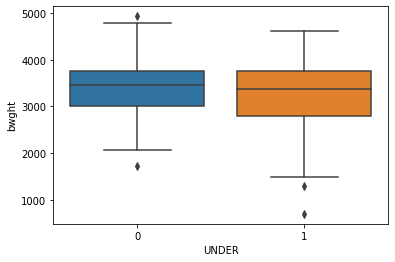

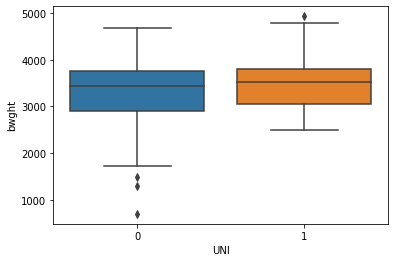

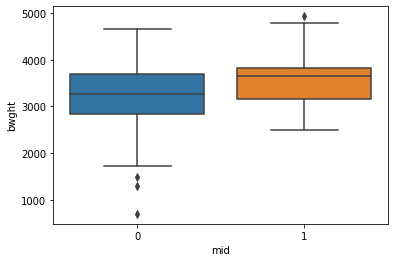

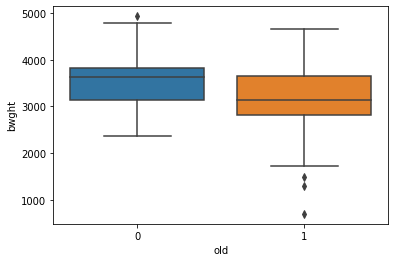

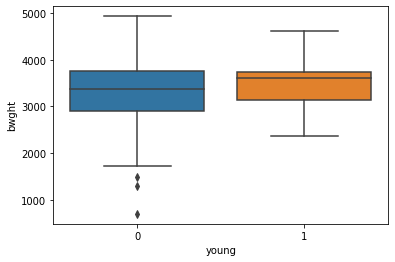

In [9]:
# developing a boxplot
for col in bw: 
    sns.boxplot(y = "bwght", x = col, data = bw)
    plt.show()
    #print(df[col].value_counts().sort_index())
    
#boxplots to see tendencies by groups

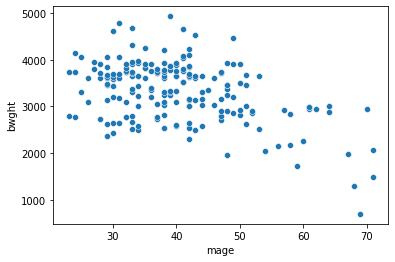

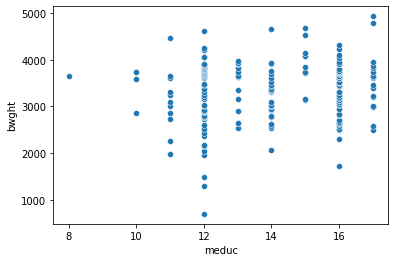

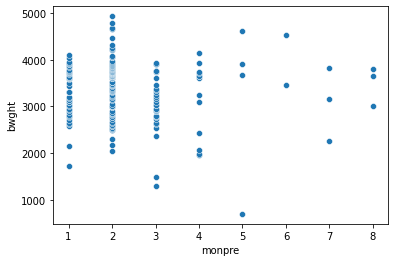

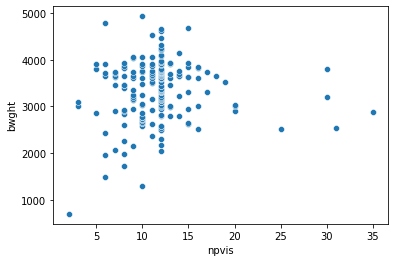

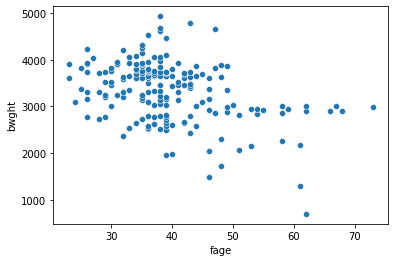

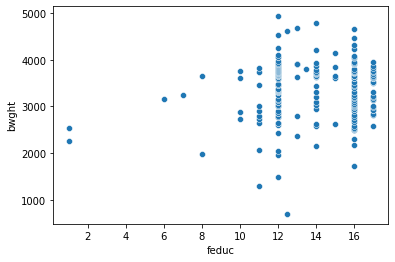

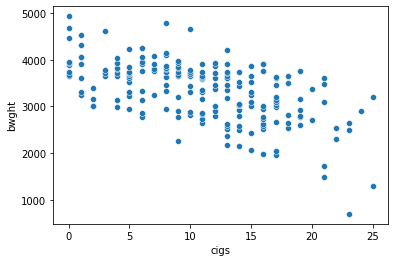

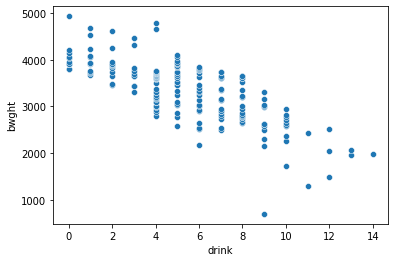

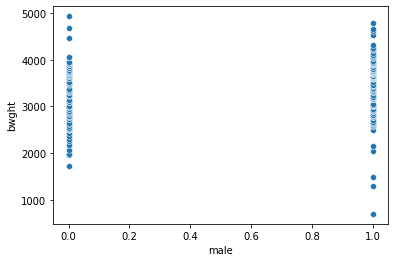

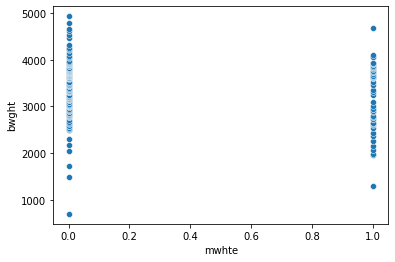

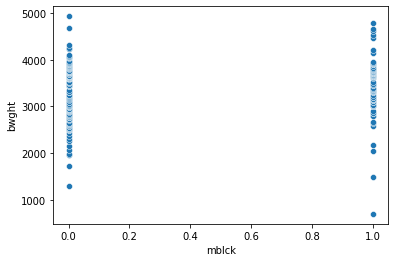

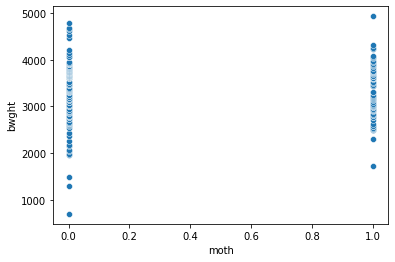

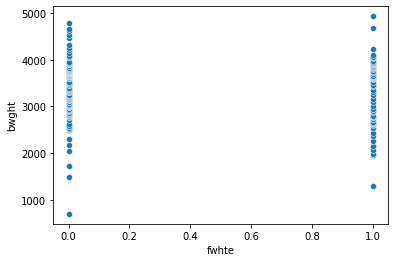

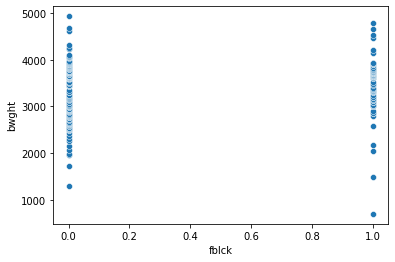

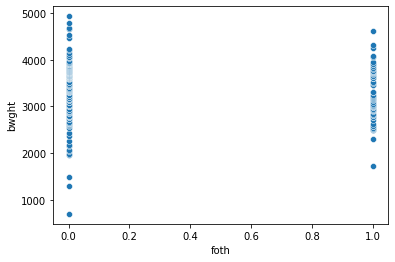

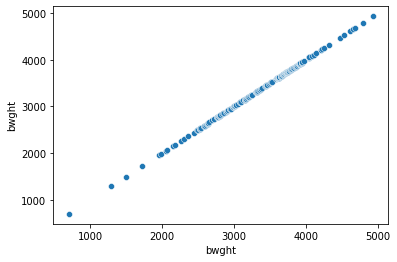

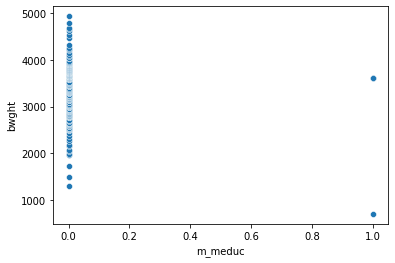

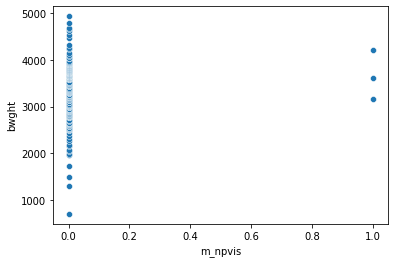

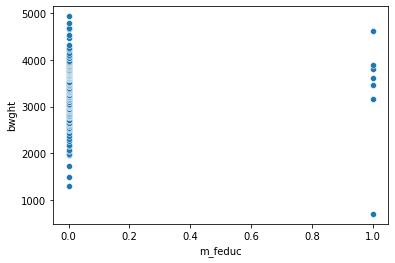

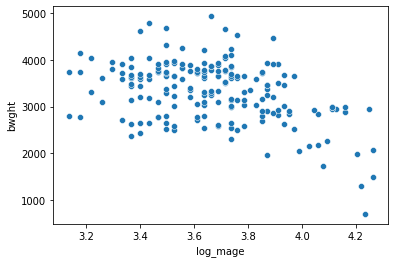

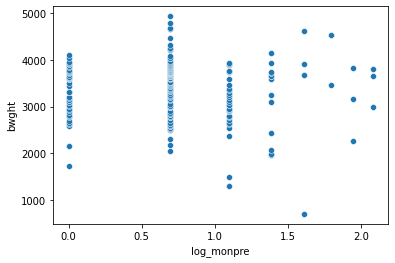

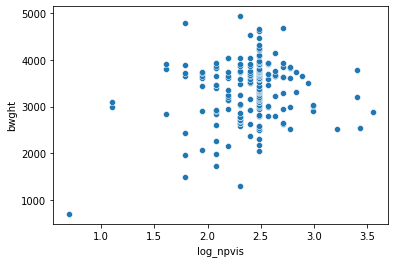

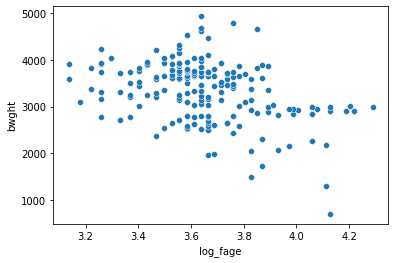

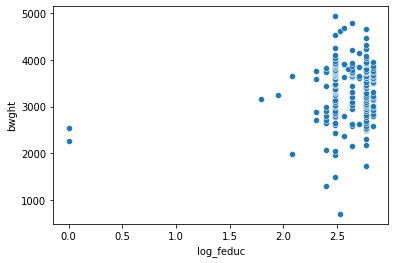

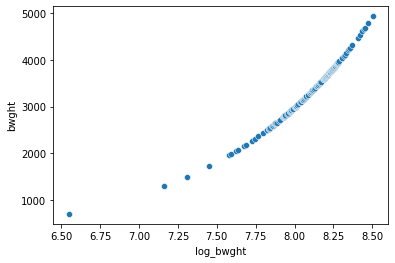

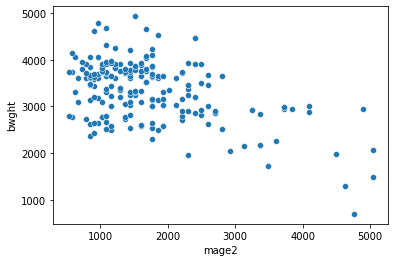

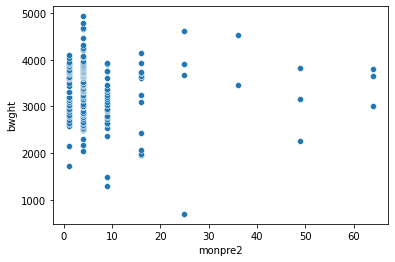

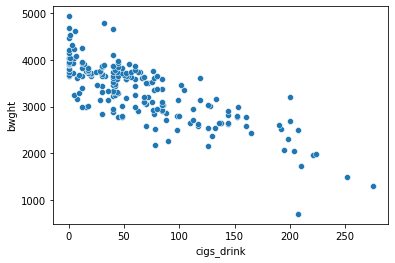

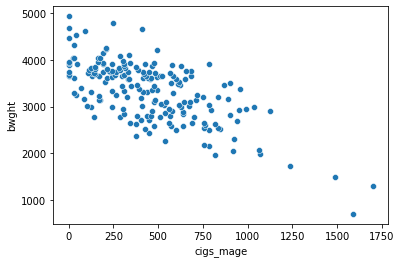

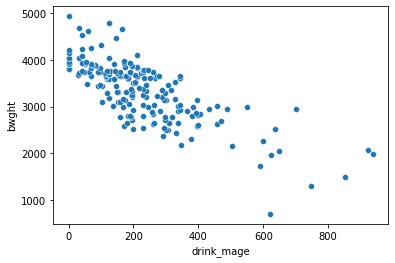

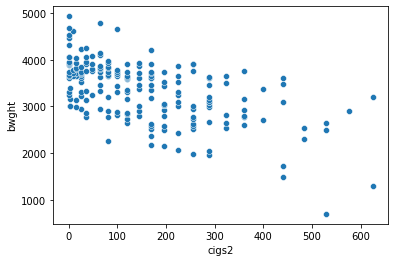

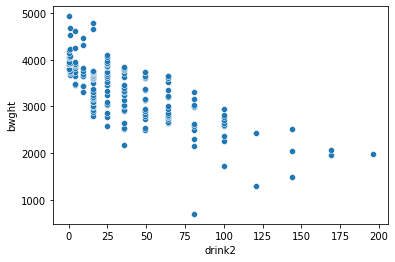

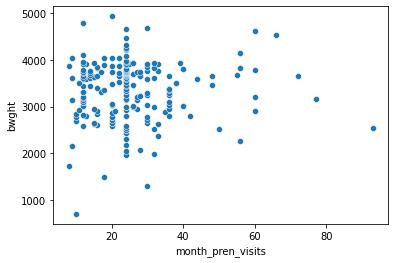

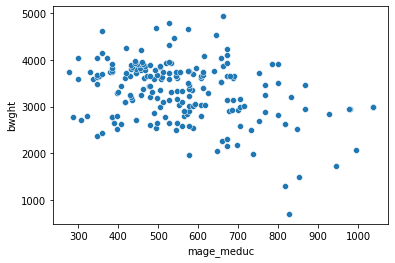

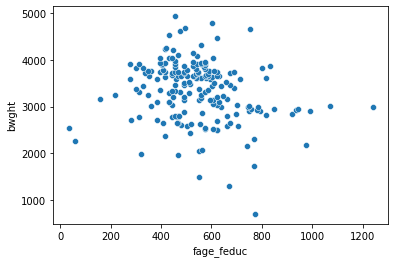

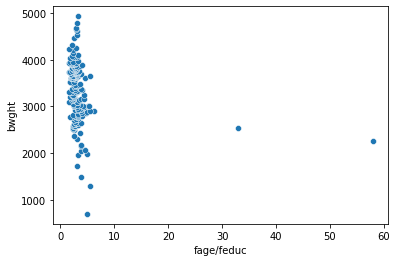

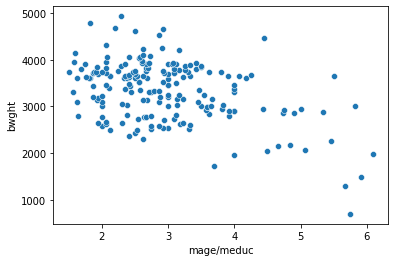

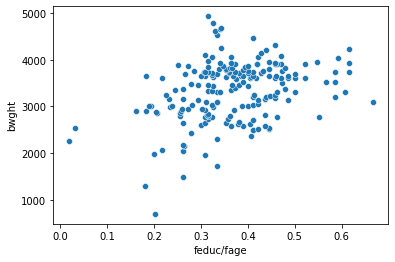

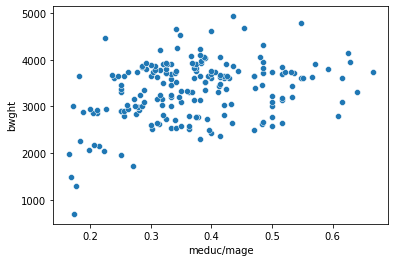

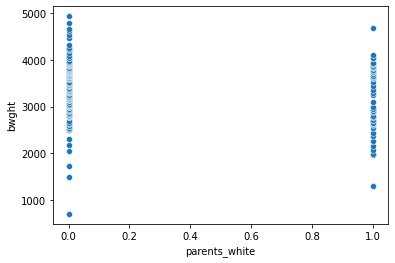

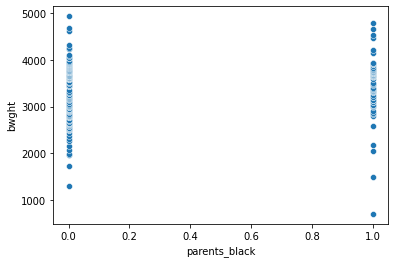

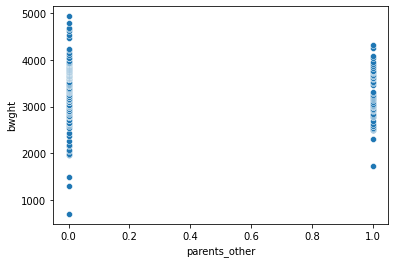

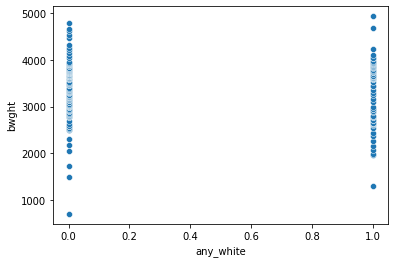

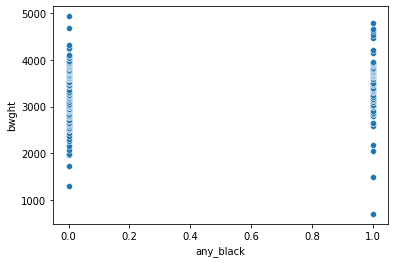

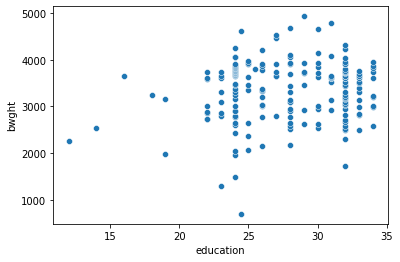

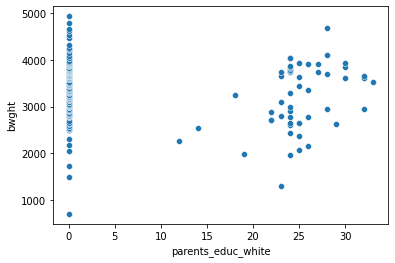

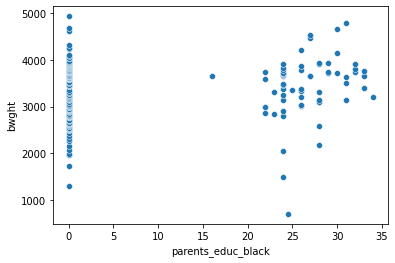

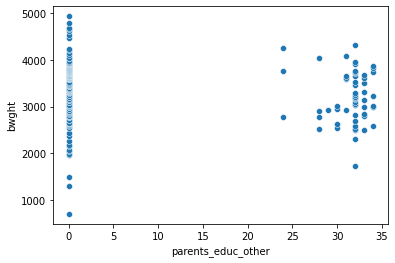

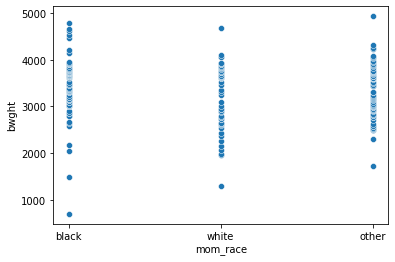

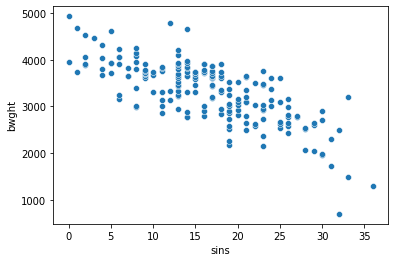

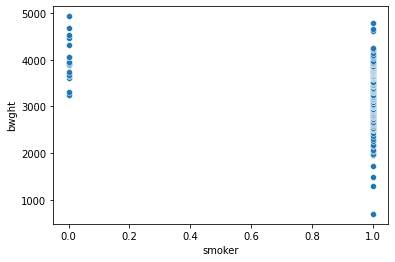

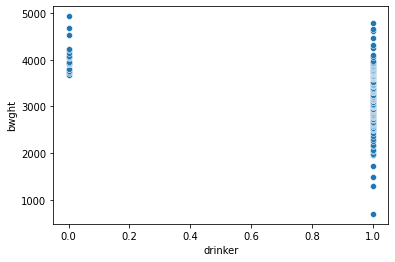

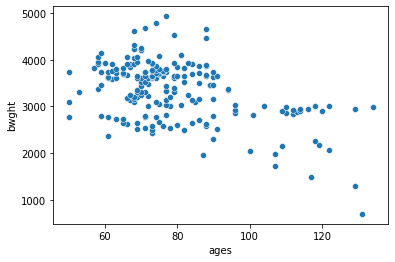

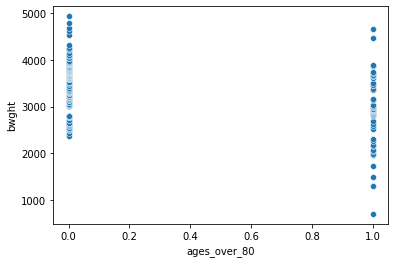

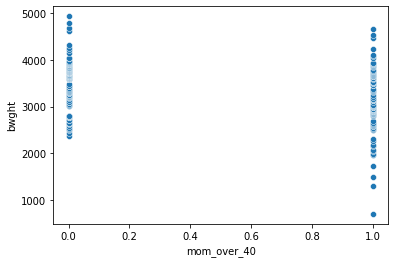

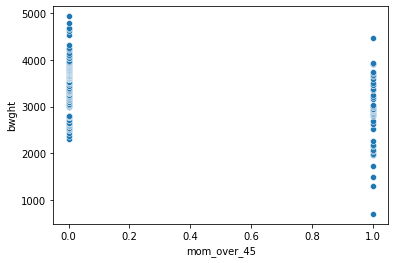

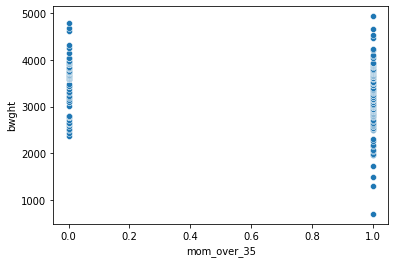

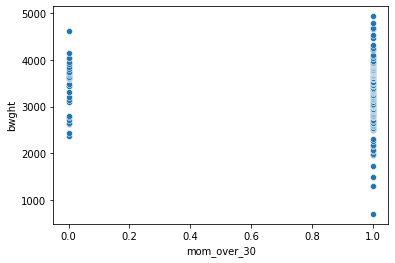

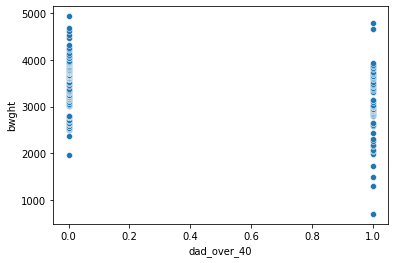

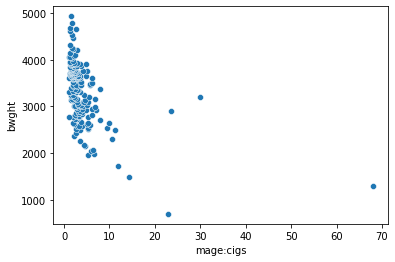

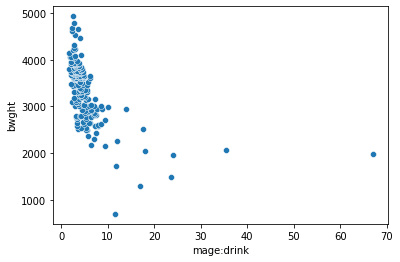

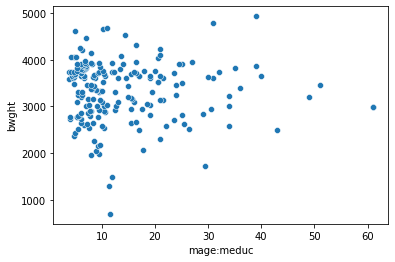

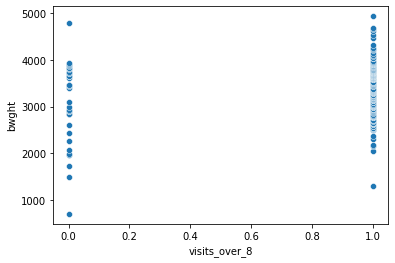

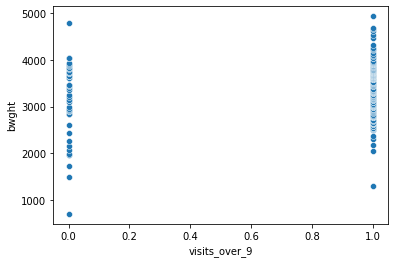

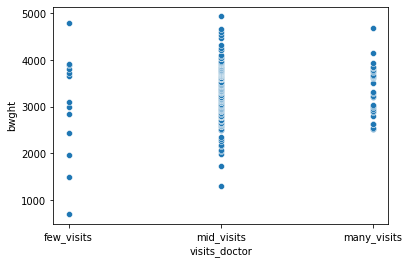

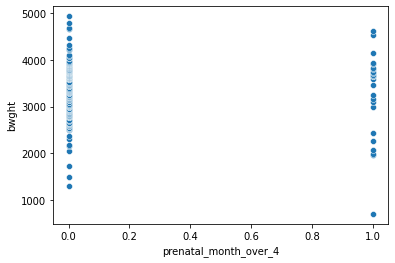

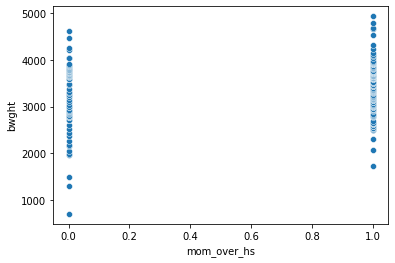

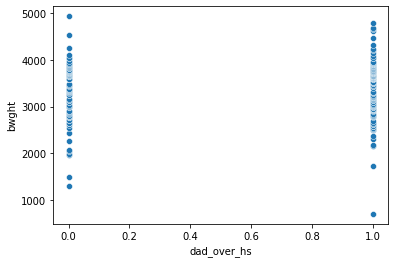

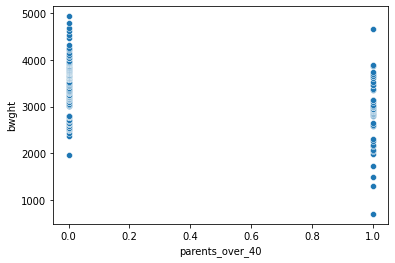

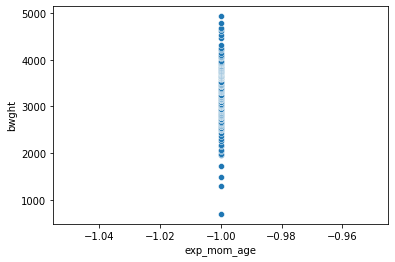

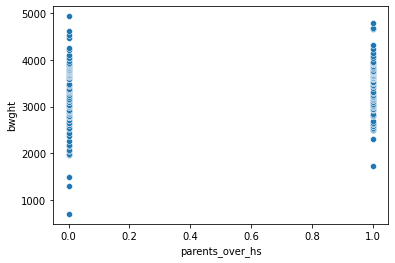

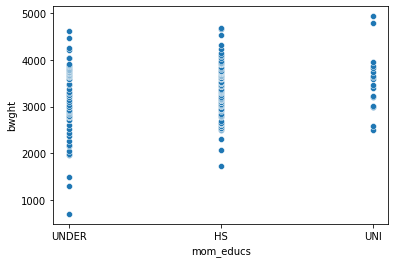

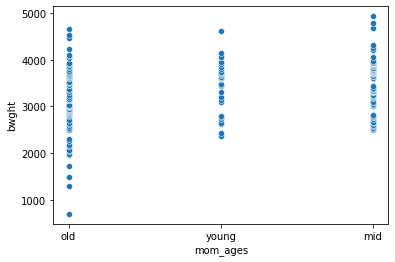

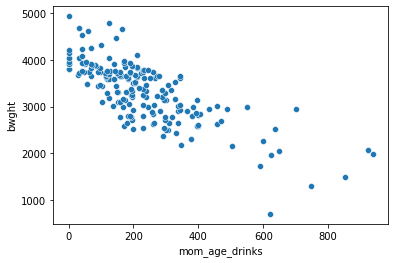

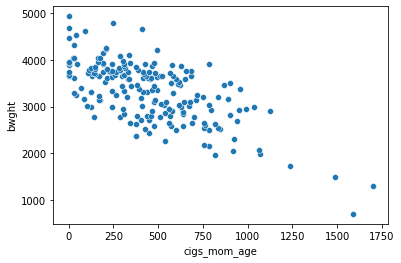

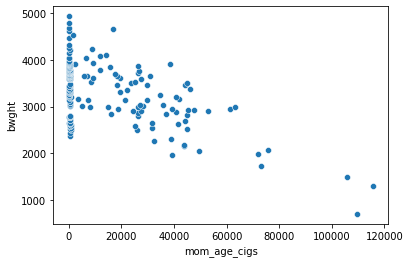

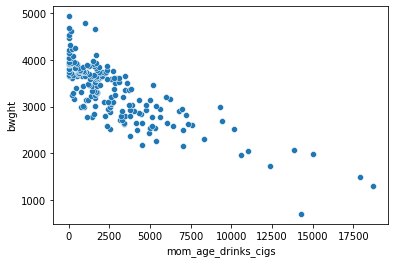

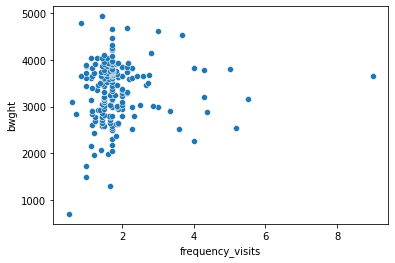

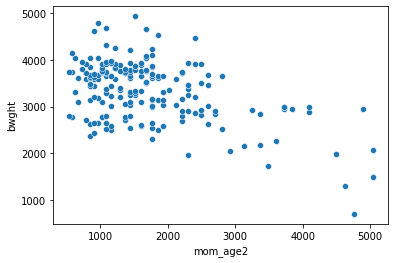

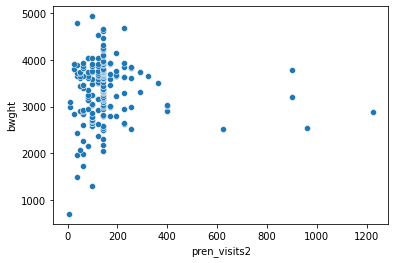

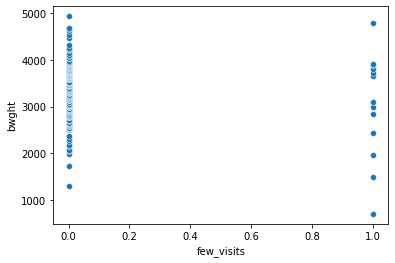

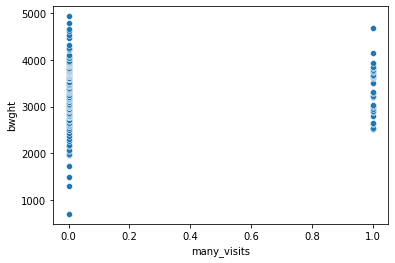

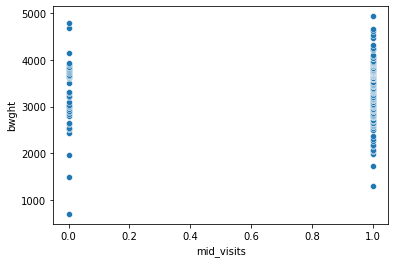

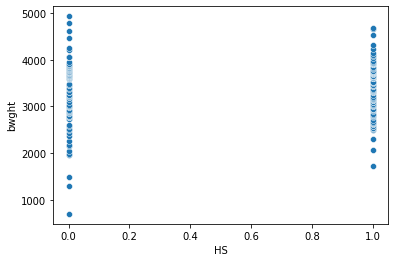

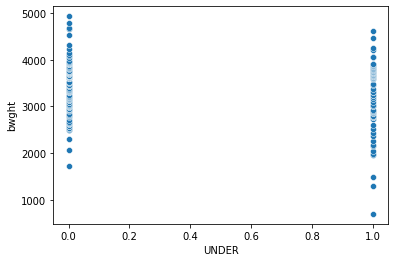

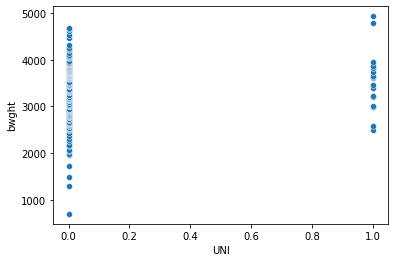

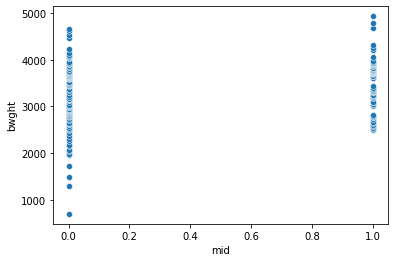

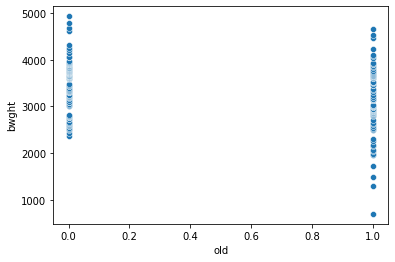

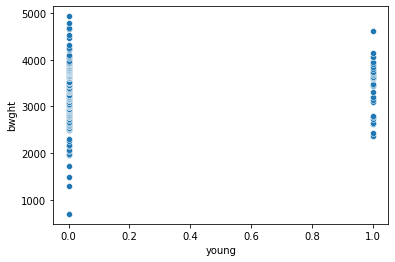

In [10]:
for col in bw.columns: 
    plt.show(sns.scatterplot(x = col, y = 'bwght', data = bw))
    
#scatterplots to see tendencies
    
    

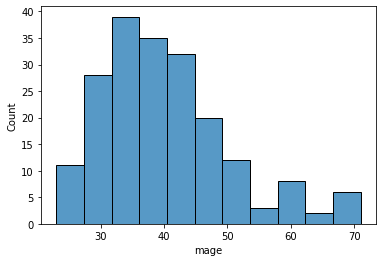

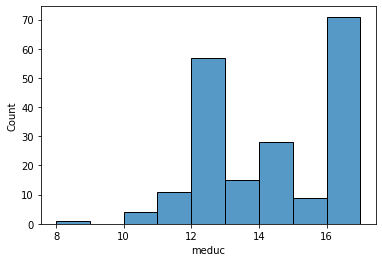

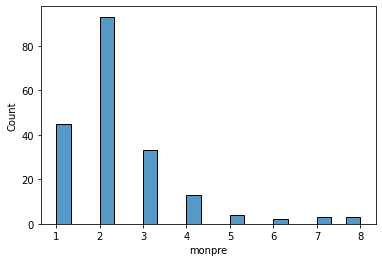

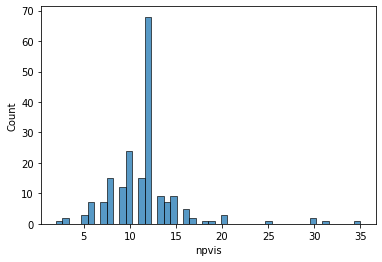

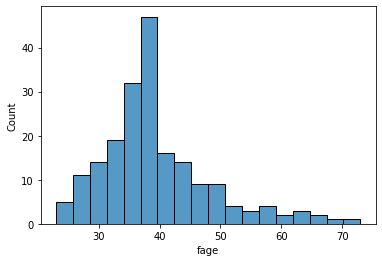

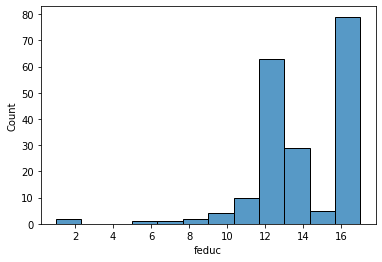

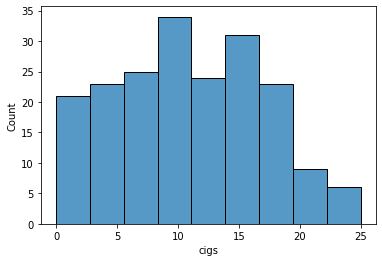

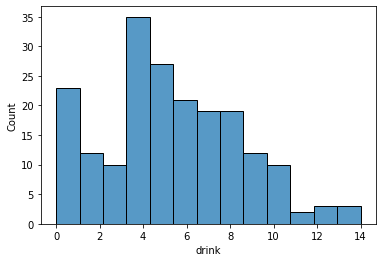

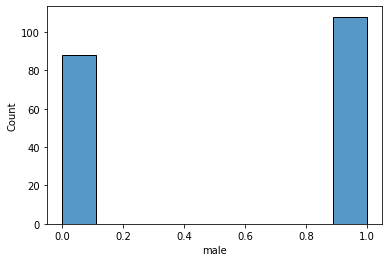

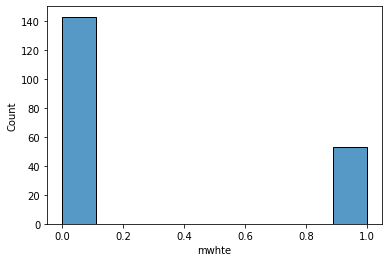

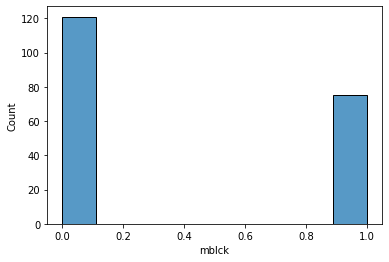

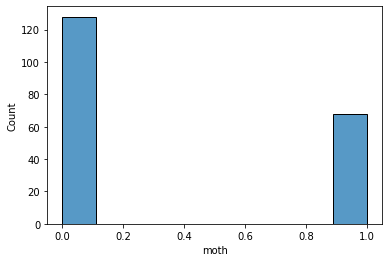

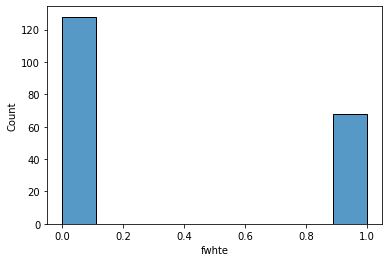

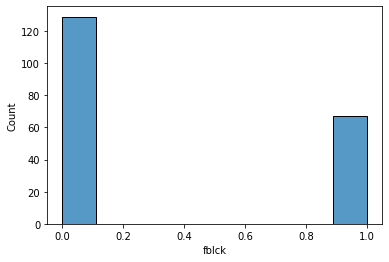

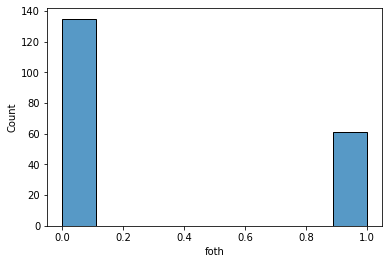

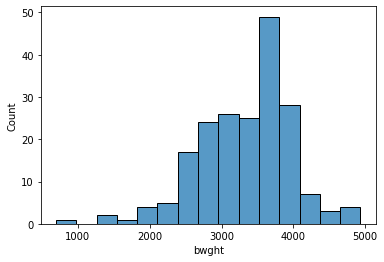

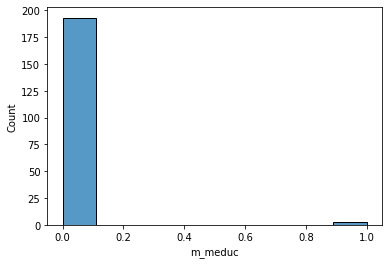

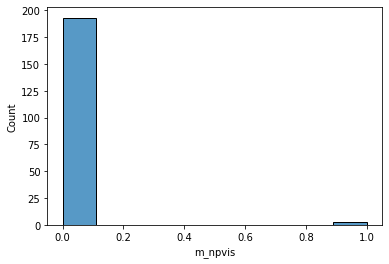

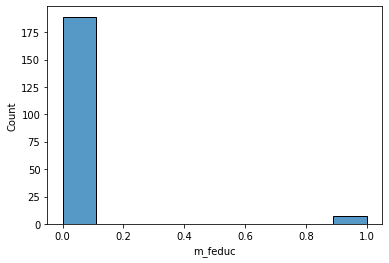

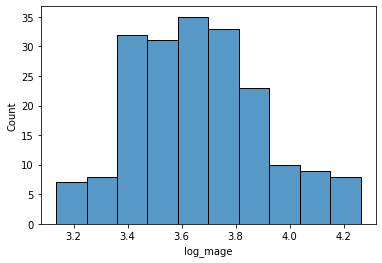

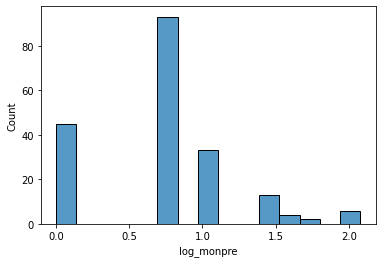

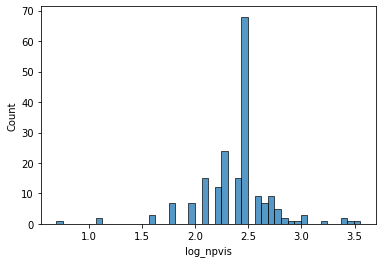

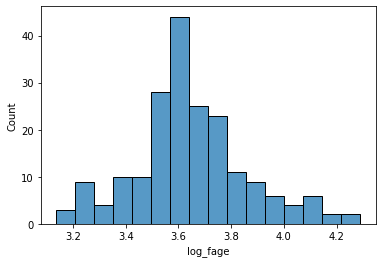

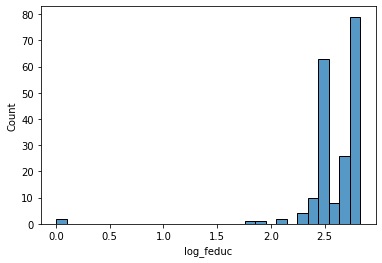

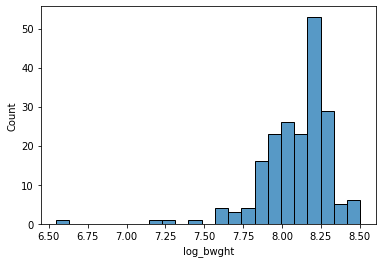

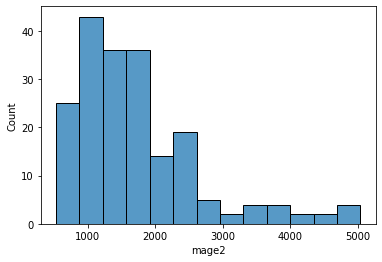

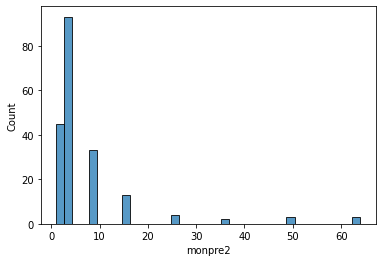

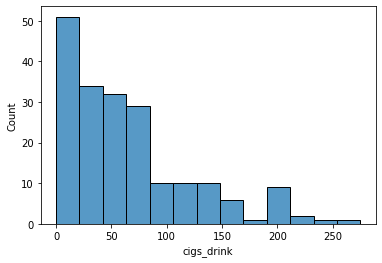

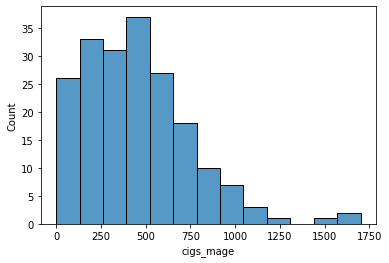

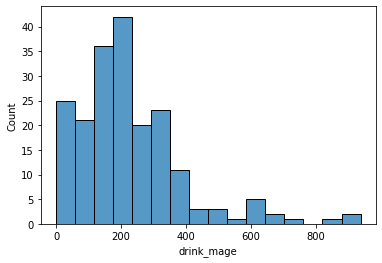

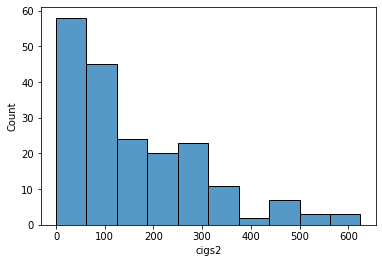

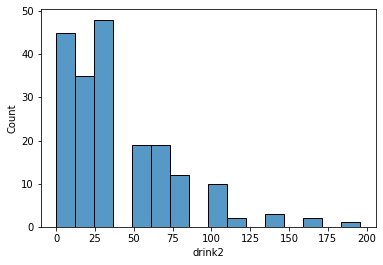

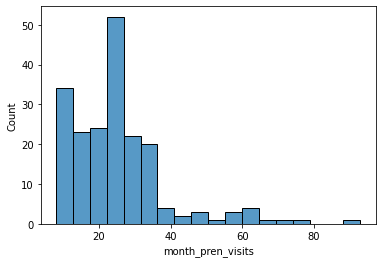

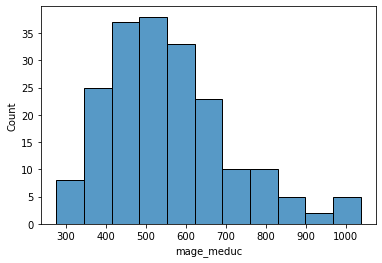

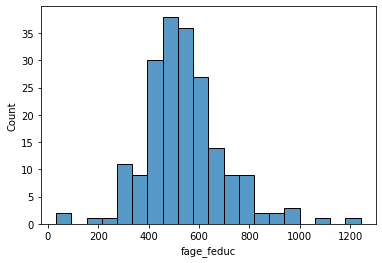

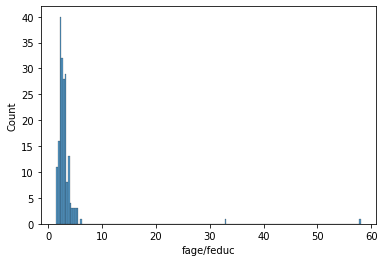

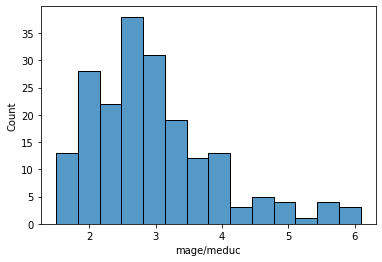

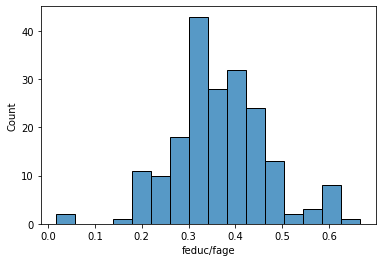

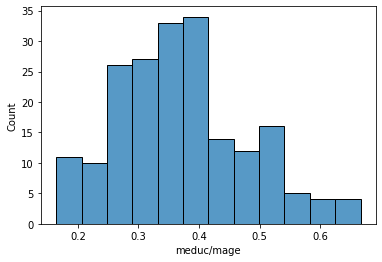

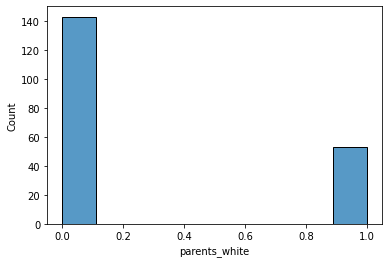

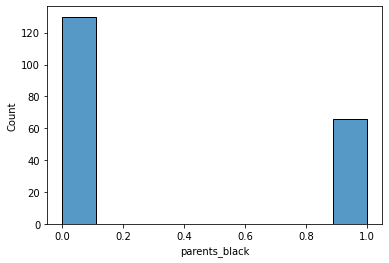

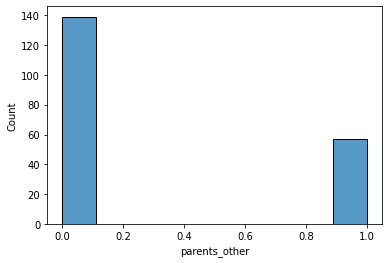

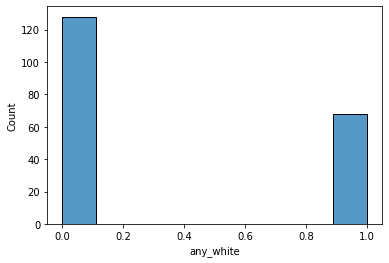

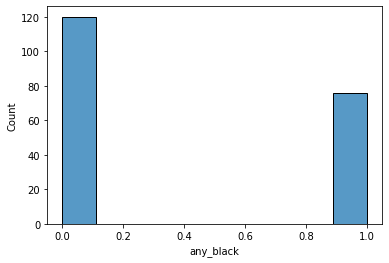

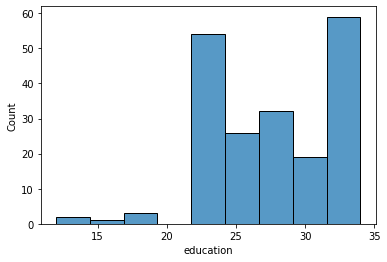

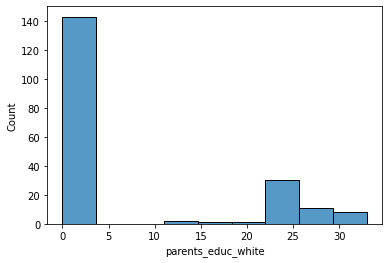

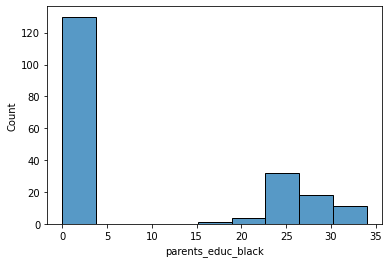

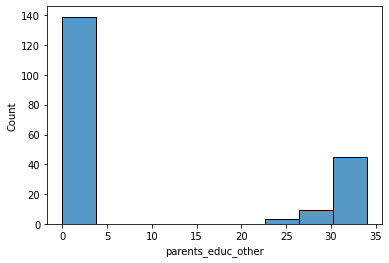

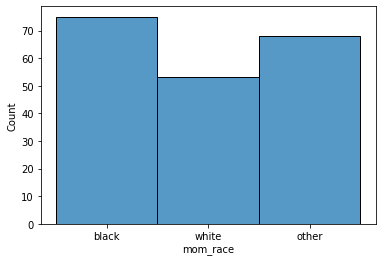

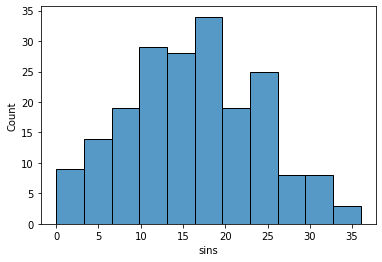

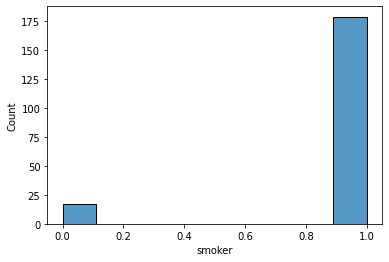

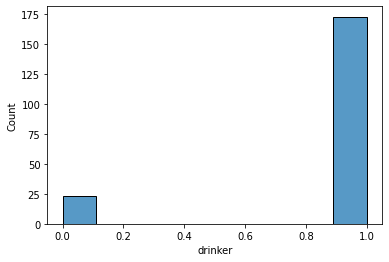

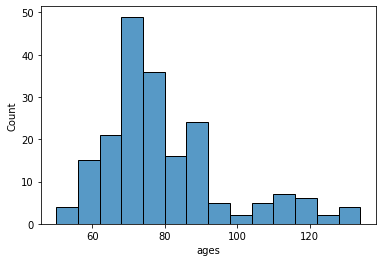

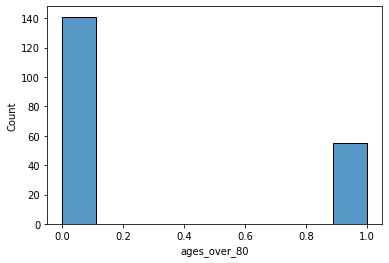

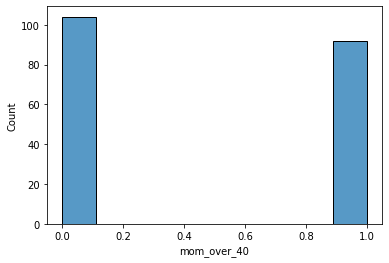

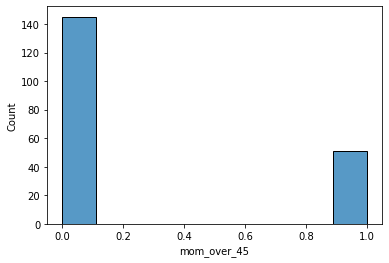

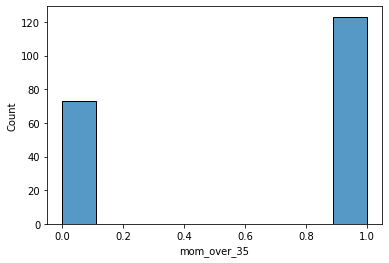

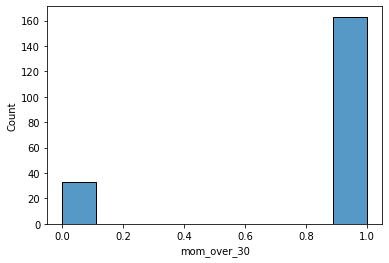

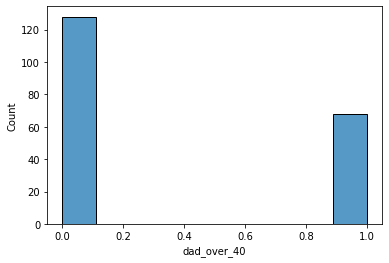

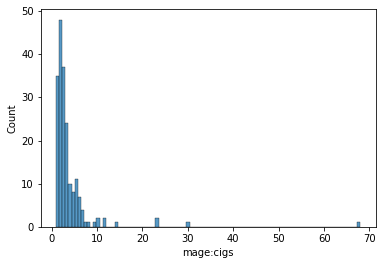

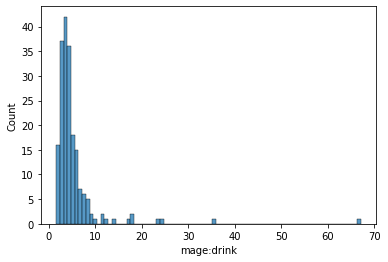

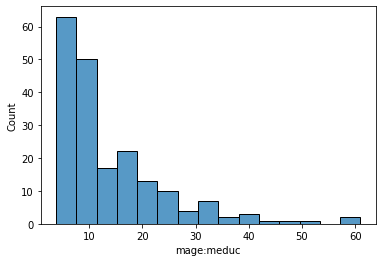

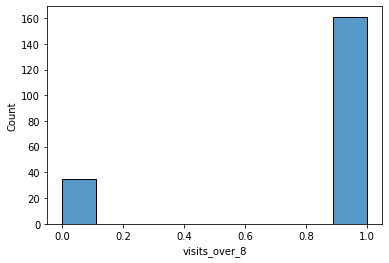

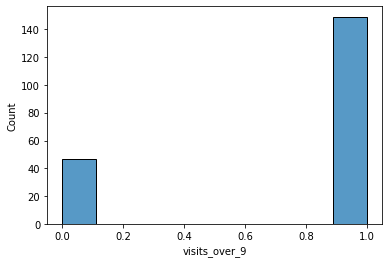

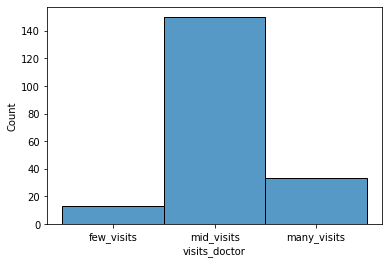

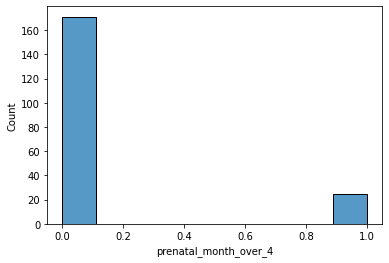

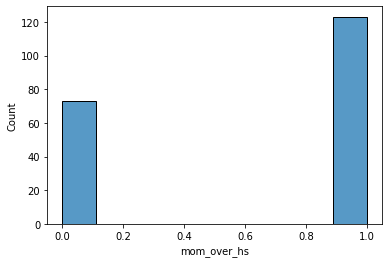

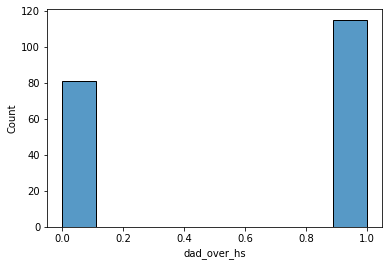

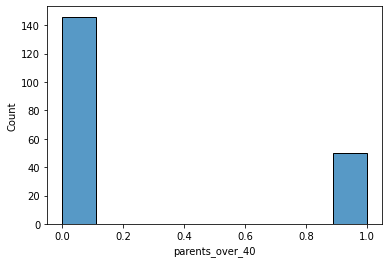

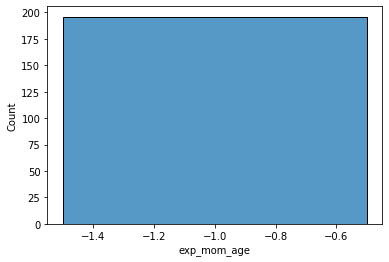

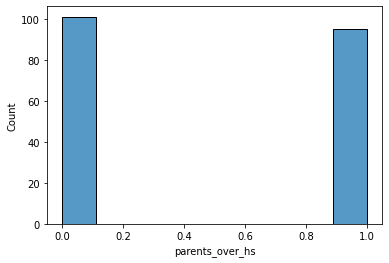

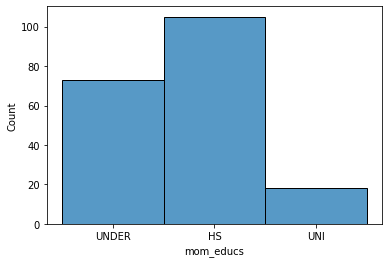

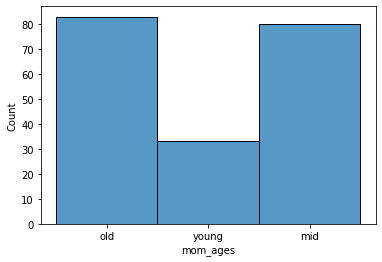

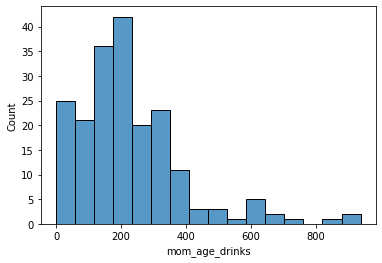

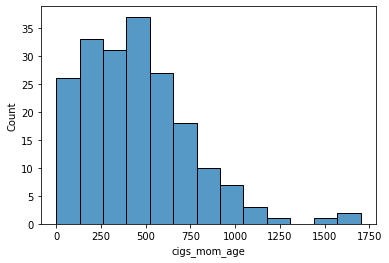

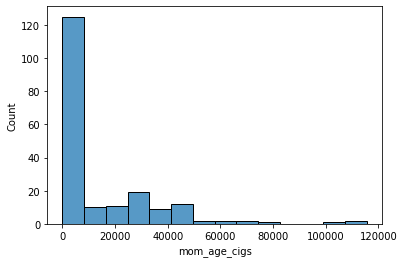

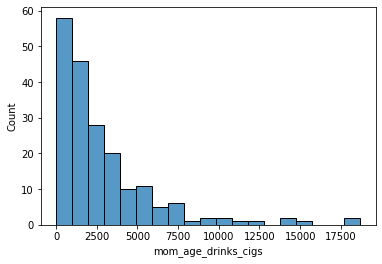

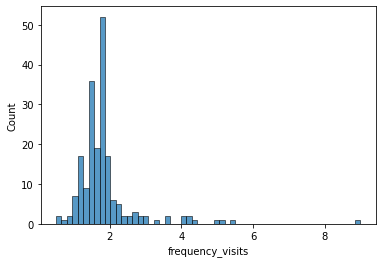

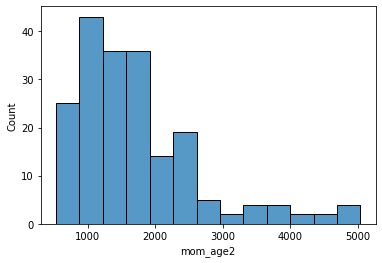

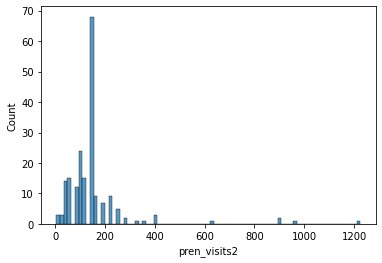

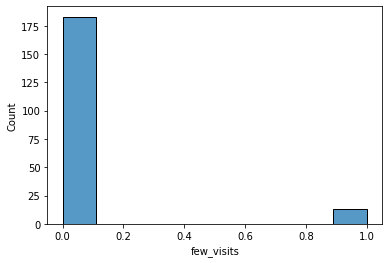

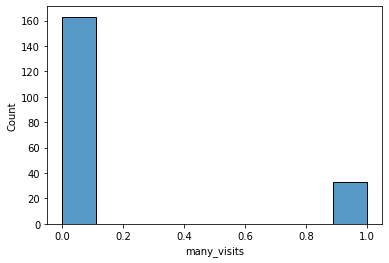

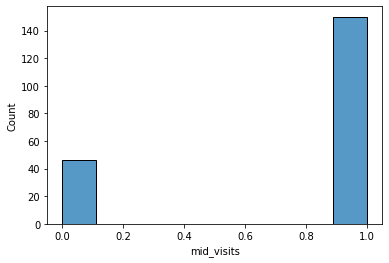

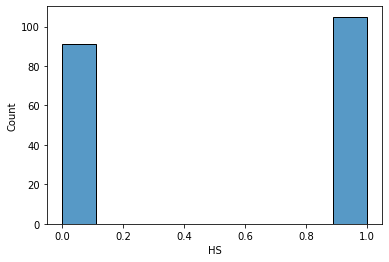

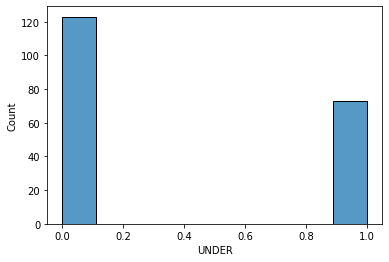

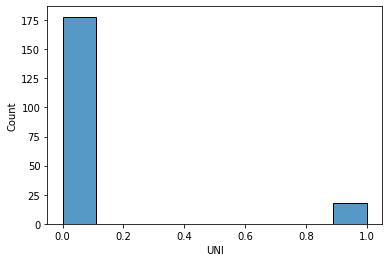

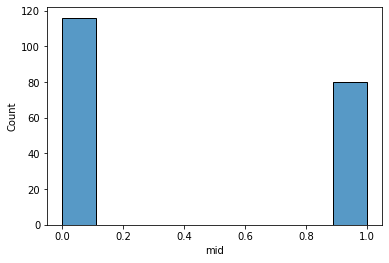

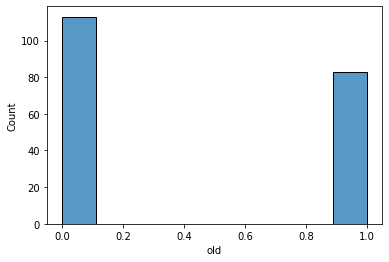

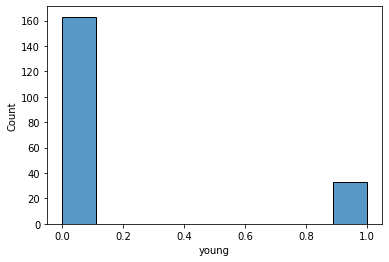

In [11]:
for col in bw.columns: 
    plt.show(sns.histplot(bw[col]))
    
#histplots to see distributions

<h2>Modeling the Data</h2>
<p>Below the models were run using the same features for each one to compare the accuracy of each using the same data. The model that best predicted on new data was chosen. Since the models are always run with the same data and the best model was not the OLS regression, this model may be affected by multicollinearity. However, this does not affect the chosen model (ARD Regression).</p>

In [9]:
features = bw.loc[:, ['cigs', 'drink','male', 'dad_over_40', 'monpre', 'dad_over_hs', 'mom_over_hs']]

# In case it matters, these combinations get over 70% with a low gap (with different imputation methods and optional arguments), but I found none that make it over 75%. Adding more columns had no effect on r2

#['cigs', 'drinks', 'male_baby', 'ln_mom_age']
#['cigs', 'drinks', 'male_baby', 'dad_over_40']
#['cigs', 'drinks', 'dad_over_40', 'male_baby', 'old', 'young']
#['cigs','drinks', 'male_baby', 'dad_over_40', 'old', 'mid']
#['cigs','drink', 'dad_over_40', 'mid', 'dad_over_hs']
#['cigs','drink', 'dad_over_40', 'mid', 'dad_over_hs', 'monpre']
#['cigs', 'drink','male', 'dad_over_40', 'mid', 'monpre','visits_over_8', 'dad_over_hs']
#['cigs', 'drink','male', 'dad_over_40', 'mid', 'monpre', 'dad_over_hs', 'mom_over_hs']
#['cigs', 'drink','male', 'dad_over_40', 'mid', 'monpre', 'dad_over_hs','log_fage']
#['cigs', 'drink','male', 'dad_over_40', 'mid', 'dad_over_hs','monpre']
#['cigs', 'drink','male', 'dad_over_40', 'mom_over_40']
#['cigs', 'drink','male', 'dad_over_40', 'monpre', 'dad_over_hs', 'mom_over_hs', 'mage:meduc']



# the linear models dont care if its scaled, so scale it so KNN does better
from sklearn.preprocessing import StandardScaler # standard scaler
# INSTANTIATING a StandardScaler() object
scaler = StandardScaler()

# FITTING the scaler with housing_data
scaler.fit(features)

# TRANSFORMING our data after fit
X_scaled = scaler.transform(features)

# converting scaled data into a DataFrame
features_scaled = pd.DataFrame(X_scaled)

y = bw.loc[:,'bwght']

#split into train and test sets for normal y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size = 0.25, random_state = 219)

y2 = bw.loc[:,'log_bwght']

#split into train and test sets for log y
X_train2, X_test2, y_train2, y_test2 = train_test_split(features_scaled, y2, test_size = 0.25, random_state = 219)


#optional arguments for each model
neighbors = 17
alpha = 1.5
algorithms = 'auto'
n_iters = 400
alpha_1 = 0.4
alpha_2 = 0.004
lambda_1 = 0.003
lambda_2 = 0.5

##########


#initiating OLS regression model
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_train, y_train) #fitting the data

pred_y3 = ols.predict(X_test) #predicting the data
pred_y2 = ols.predict(X_train)

ols_test = ols.score(X_test, y_test).round(decimals=4) #checking the r squared of the model
ols_train = ols.score(X_train, y_train).round(decimals=4)
ols_gap = abs(ols_train - ols_test).round(4) #noting the gap between scores



from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = neighbors, algorithm = algorithms)
knn.fit(X_train, y_train) #fitting the data

pred_y3 = knn.predict(X_test) #predicting the data
pred_y2 = knn.predict(X_train)

knn_test = knn.score(X_test, y_test).round(decimals=4) #checking the r squared of the model
knn_train = knn.score(X_train, y_train).round(decimals=4)
knn_gap = abs(knn_train - knn_test).round(4)  #noting the gap between scores


from sklearn.linear_model import Lasso

lasso = Lasso(alpha = alpha)
lasso.fit(X_train, y_train) #fitting the data

pred_y = lasso.predict(X_test) #predicting the data
pred_y1 = lasso.predict(X_train)


lasso_test = lasso.score(X_test, y_test).round(decimals=4) #checking the r squared of the model
lasso_train = lasso.score(X_train, y_train).round(decimals=4)
lasso_gap = abs(lasso_train - lasso_test).round(4)  #noting the gap between scores


from sklearn.linear_model import ARDRegression 
ARDR = ARDRegression(n_iter = n_iters, alpha_1 = alpha_1, alpha_2 = alpha_2, lambda_1 = lambda_1, lambda_2 = lambda_2)
ARDR.fit(X_train, y_train) #fitting the data

pred_y4 = ARDR.predict(X_test) #predicting the data
pred_y5 = ARDR.predict(X_train)

ARDR_test = ARDR.score(X_test, y_test).round(decimals=4) #checking the r squared of the model
ARDR_train = ARDR.score(X_train, y_train).round(decimals=4)
ARDR_gap = abs(ARDR_train - ARDR_test).round(4)  #noting the gap between scores


#############################################################

from sklearn.linear_model import LinearRegression

ols2 = LinearRegression()
ols2.fit(X_train2, y_train2) #fitting the data

pred_y3 = ols2.predict(X_test2) #predicting the data
pred_y2 = ols2.predict(X_train2)

ols_ln_test = ols2.score(X_test2, y_test2).round(decimals=4) #checking the r squared of the model
ols_ln_train = ols2.score(X_train2, y_train2).round(decimals=4)
ols_ln_gap = abs(ols_ln_train - ols_ln_test).round(4)  #noting the gap between scores


from sklearn.neighbors import KNeighborsRegressor

knn2 = KNeighborsRegressor(n_neighbors = neighbors)
knn2.fit(X_train2, y_train2) #fitting the data

pred_y3 = knn2.predict(X_test2) #predicting the data
pred_y2 = knn2.predict(X_train2)

knn_ln_test = knn2.score(X_test2, y_test2).round(decimals=4) #checking the r squared of the model
knn_ln_train = knn2.score(X_train2, y_train2).round(decimals=4)
knn_ln_gap = abs(knn_ln_train - knn_ln_test).round(4)  #noting the gap between scores


from sklearn.linear_model import Lasso

lasso2 = Lasso(alpha = alpha)
lasso2.fit(X_train2, y_train2) #fitting the data

pred_y = lasso2.predict(X_test2) #predicting the data
pred_y1 = lasso2.predict(X_train2)

lasso_ln_test = lasso2.score(X_test2, y_test2).round(decimals=4) #checking the r squared of the model
lasso_ln_train = lasso2.score(X_train2, y_train2).round(decimals=4)
lasso_ln_gap = abs(lasso_ln_train - lasso_ln_test).round(4)  #noting the gap between scores

from sklearn.linear_model import ARDRegression 
ARDR2 = ARDRegression()
ARDR2.fit(X_train2, y_train2) #fitting the data
 
pred_y4 = ARDR2.predict(X_test2) #predicting the data
pred_y5 = ARDR2.predict(X_train2)


ARDR_ln_test = ARDR2.score(X_test2, y_test2).round(decimals=4) #checking the r squared of the model
ARDR_ln_train = ARDR2.score(X_train2, y_train2).round(decimals=4)
ARDR_ln_gap = abs(ARDR_ln_train - ARDR_ln_test).round(4)  #noting the gap between scores
 

<h3>Results</h3>
<p>Below is a comparison of all allowed models. The best score was achieved using the Bayesian Automatic Relevance Determination. It has a score of 72.35% on the test set, and 68.65% on the train set. The gap is 3.7%</p>

In [10]:
#importing table output library
from tabulate import tabulate

#storing the strings and other variables to be printed
table = [["OLS",ols_train,ols_test, ols_gap],["KNN",knn_train,knn_test, knn_gap],["Lasso",lasso_train,lasso_test, lasso_gap], ["ARD (Final Model)",ARDR_train,ARDR_test, ARDR_gap], ["OLS log",ols_ln_train,ols_ln_test,ols_ln_gap], ["KNN log",knn_ln_train,knn_ln_test,knn_ln_gap], ["Lasso log",lasso_ln_train,lasso_ln_test, lasso_ln_gap], ["ARD log",ARDR_ln_train,ARDR_ln_test,ARDR_ln_gap]]

# printing the results in a table
print(tabulate(table, headers=["Regression", "Train score", "Test score", "Gap"], tablefmt="fancy_grid"))

#I asked but I haven't heard back if this counts as a dynamic string so I am going to print it again manually I guess. 

╒═══════════════════╤═══════════════╤══════════════╤════════╕
│ Regression        │   Train score │   Test score │    Gap │
╞═══════════════════╪═══════════════╪══════════════╪════════╡
│ OLS               │        0.6903 │       0.7002 │ 0.0099 │
├───────────────────┼───────────────┼──────────────┼────────┤
│ KNN               │        0.5752 │       0.4046 │ 0.1706 │
├───────────────────┼───────────────┼──────────────┼────────┤
│ Lasso             │        0.6902 │       0.7023 │ 0.0121 │
├───────────────────┼───────────────┼──────────────┼────────┤
│ ARD (Final Model) │        0.6865 │       0.7235 │ 0.037  │
├───────────────────┼───────────────┼──────────────┼────────┤
│ OLS log           │        0.6259 │       0.689  │ 0.0631 │
├───────────────────┼───────────────┼──────────────┼────────┤
│ KNN log           │        0.5364 │       0.4205 │ 0.1159 │
├───────────────────┼───────────────┼──────────────┼────────┤
│ Lasso log         │        0      │      -0.0028 │ 0.0028 │
├───────

In [11]:
#printing the results in a dynamic string
model = "Model" 
traiin = "Train"
tesst = "Test"
gapp = "Gap"
print(f"""%-20s | %-7s | %-7s | %-6s \n{"-"*50}\n%-20s | %-7s | %-7s | %-6s \n%-20s | %-7s | %-7s | %-6s \n%-20s | %-7s | %-7s | %-6s """ %(model, traiin, tesst, gapp, table[0][0], table[0][1], table[0][2], table[0][3], table[1][0], table[1][1], table[1][2], table[1][3], table[2][0], table[2][1], table[2][2], table[2][3]) + "\033[1m" + "\n%-20s | %-7s | %-7s | %-6s" %(table[3][0], table[3][1], table[3][2], table[3][3]) + "\033[0m" + """\n%-20s | %-7s | %-7s | %-6s \n%-20s | %-7s | %-7s | %-6s \n%-20s | %-6s  |%-8s | %-6s \n%-20s | %-7s | %-7s | %-6s """ %( table[4][0], table[4][1], table[4][2], table[4][3], table[5][0], table[5][1], table[5][2], table[5][3], table[6][0], table[6][1], table[6][2], table[6][3], table[7][0], table[7][1], table[7][2], table[7][3]))

Model                | Train   | Test    | Gap    
--------------------------------------------------
OLS                  | 0.6903  | 0.7002  | 0.0099 
KNN                  | 0.5752  | 0.4046  | 0.1706 
Lasso                | 0.6902  | 0.7023  | 0.0121 
ARD (Final Model)    | 0.6865  | 0.7235  | 0.037 
OLS log              | 0.6259  | 0.689   | 0.0631 
KNN log              | 0.5364  | 0.4205  | 0.1159 
Lasso log            | 0.0     |-0.0028  | 0.0028 
ARD log              | 0.6219  | 0.7111  | 0.0892 


<h2>Postmortem</h2>
<p>The following code was run various times after defining the features to be used, and helped determine which features were helping the model or what arguments to use. I have also locked these so they don't slow down the notebook when running it. </p>

In [14]:
# zipping each feature name to its coefficient
lasso_model_values = zip(features, lasso.coef_.round(decimals = 2))


# setting up a placeholder list to store model features
lasso_model_lst = [('intercept', lasso.intercept_.round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for val in lasso_model_values:
    lasso_model_lst.append(val)
    

# checking the results
for pair in lasso_model_lst:
    print(pair)
    
   


('intercept', 3358.69)
('cigs', -239.49)
('drink', -356.49)
('male', 30.59)
('dad_over_40', -107.16)
('monpre', -24.34)
('dad_over_hs', -5.07)
('mom_over_hs', 74.83)


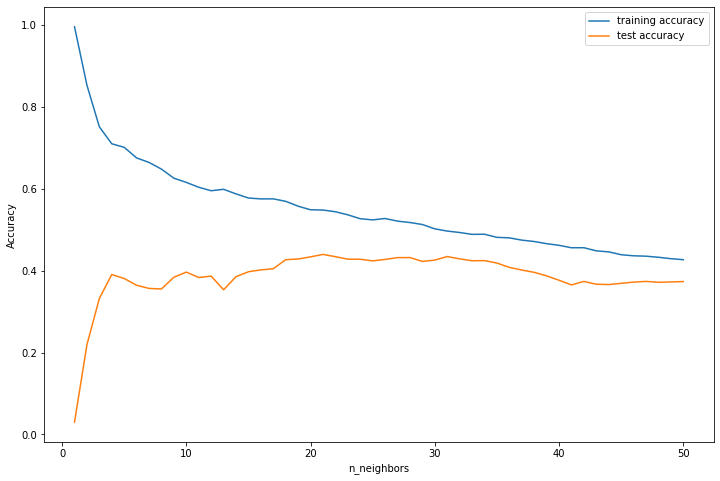

In [15]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 1 to 50 neighbors
neighbors_settings = range(1, 51)


for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors = n_neighbors)
    clf.fit(X_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()